# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

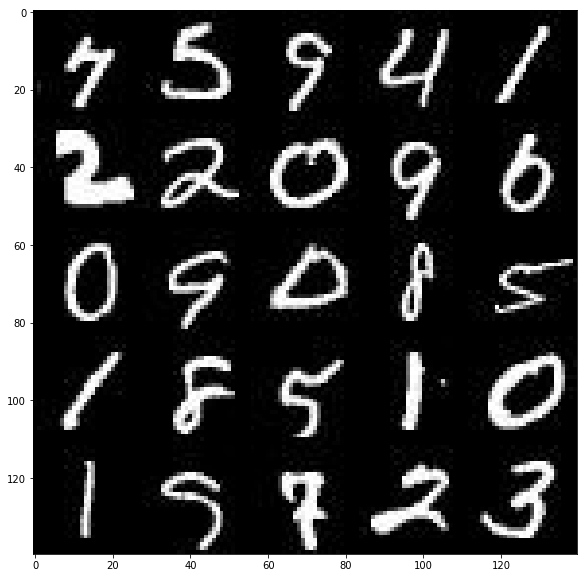

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot
pyplot.figure(figsize=(10,10))


mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

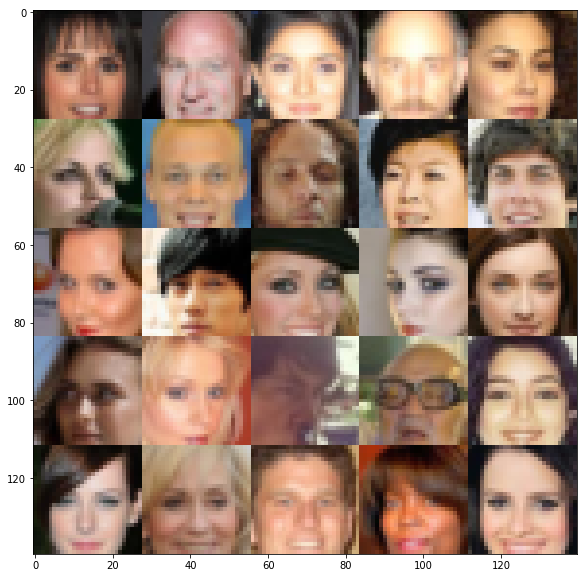

In [4]:
show_n_images = 25
pyplot.figure(figsize=(10,10))

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels),'input_real')
    z_inputs = tf.placeholder(tf.float32, (None, z_dim), 'z_inputs')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return input_real, z_inputs, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [8]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        alpha = 0.2
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='SAME', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x1 = tf.maximum(alpha * x1, x1)

        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='SAME', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)

            
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='SAME', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)
        drop = tf.layers.dropout(x3, rate=0.1)
        
        # Flatten it
        flat = tf.reshape(drop, (-1, 4*4*256))

        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)        
       
        return out, logits



    
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [10]:
def generator(z, out_channel_dim, is_train=True):

    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
  # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        alpha=0.2

        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*1024)
        x1 = tf.reshape(x1, (-1, 7, 7, 1024))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)

        
        x2 = tf.layers.conv2d_transpose(x1, 512, 5, strides=2, padding='SAME', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 256, 5, strides=2, padding='SAME', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        
        x4 = tf.layers.conv2d_transpose(x3, 128, 3, strides=1, padding='SAME', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha * x4, x4)
        
        x5 = tf.layers.conv2d_transpose(x4, 64, 3, strides=1, padding='SAME', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x5 = tf.layers.batch_normalization(x5, training=is_train)
        x5 = tf.maximum(alpha * x5, x5)
     
            
        # Output layer
        logits = tf.layers.conv2d_transpose(x5, out_channel_dim, 3, strides=1, padding='SAME', kernel_initializer=tf.contrib.layers.xavier_initializer())
        out = tf.tanh(logits)        
        
        return out
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [11]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [12]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]  

    # Updating both generator and discriminator
    
    ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_updates = [opt for opt in ops if opt.name.startswith('generator')]
    with tf.control_dependencies(g_updates):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(g_loss, var_list=g_vars)
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)

            
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [13]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.figure(figsize=(10,10))
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [14]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # Build Model
    _, img_width, img_height, img_channels = data_shape    
    input_real, z_input, lr = model_inputs(img_width, img_height, img_channels, z_dim)    
    d_loss, g_loss = model_loss(input_real, z_input, img_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    print_every = 20
    show_every = 200
    losses = []
    n_images = 25
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                batch_images *= 2
                z_sample = np.random.uniform(-1, 1, (batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={
                        input_real: batch_images, z_input: z_sample, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={
                        z_input: z_sample, lr: learning_rate})
                
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({z_input: z_sample, input_real: batch_images})
                    train_loss_g = g_loss.eval({z_input: z_sample})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))
                
                if steps % show_every == 0:
                    show_generator_output(sess, n_images, z_input, img_channels, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.0497... Generator Loss: 7.1175
Epoch 1/2... Discriminator Loss: 0.3475... Generator Loss: 2.7797
Epoch 1/2... Discriminator Loss: 1.5158... Generator Loss: 1.4266
Epoch 1/2... Discriminator Loss: 1.7049... Generator Loss: 0.5957
Epoch 1/2... Discriminator Loss: 1.4480... Generator Loss: 0.9742
Epoch 1/2... Discriminator Loss: 1.1931... Generator Loss: 0.7904
Epoch 1/2... Discriminator Loss: 1.4277... Generator Loss: 0.5924
Epoch 1/2... Discriminator Loss: 1.3032... Generator Loss: 0.6477
Epoch 1/2... Discriminator Loss: 1.4731... Generator Loss: 0.6688
Epoch 1/2... Discriminator Loss: 1.4034... Generator Loss: 0.7630


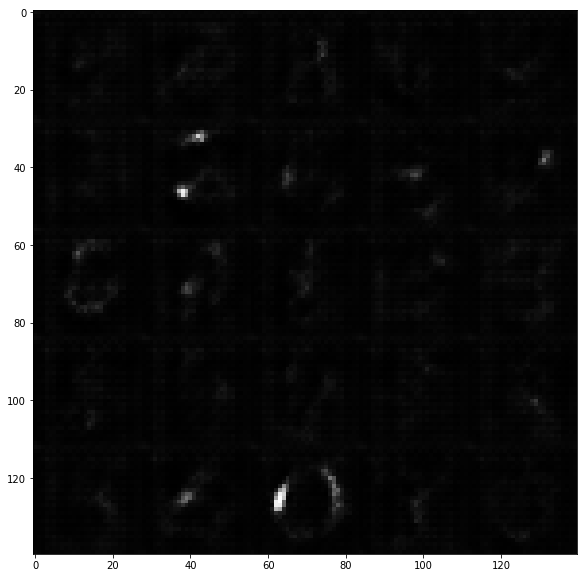

Epoch 1/2... Discriminator Loss: 1.6450... Generator Loss: 0.3115
Epoch 1/2... Discriminator Loss: 1.4715... Generator Loss: 0.4159
Epoch 1/2... Discriminator Loss: 1.4645... Generator Loss: 0.7112
Epoch 1/2... Discriminator Loss: 1.7272... Generator Loss: 0.2772
Epoch 1/2... Discriminator Loss: 1.3980... Generator Loss: 0.7905
Epoch 1/2... Discriminator Loss: 1.3800... Generator Loss: 0.5937
Epoch 1/2... Discriminator Loss: 1.3878... Generator Loss: 0.8905
Epoch 1/2... Discriminator Loss: 1.7081... Generator Loss: 0.3148
Epoch 1/2... Discriminator Loss: 1.3749... Generator Loss: 0.7096
Epoch 1/2... Discriminator Loss: 1.3579... Generator Loss: 0.6229


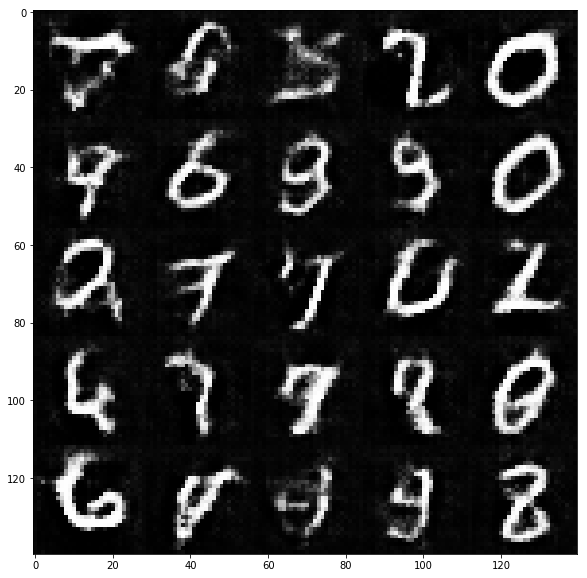

Epoch 1/2... Discriminator Loss: 1.3217... Generator Loss: 0.7782
Epoch 1/2... Discriminator Loss: 1.4099... Generator Loss: 0.4357
Epoch 1/2... Discriminator Loss: 1.5003... Generator Loss: 0.4509
Epoch 1/2... Discriminator Loss: 1.4823... Generator Loss: 0.4581
Epoch 1/2... Discriminator Loss: 1.3103... Generator Loss: 0.9097
Epoch 1/2... Discriminator Loss: 1.3309... Generator Loss: 0.5904
Epoch 1/2... Discriminator Loss: 1.4358... Generator Loss: 0.4843
Epoch 1/2... Discriminator Loss: 1.3313... Generator Loss: 0.5586
Epoch 1/2... Discriminator Loss: 1.4802... Generator Loss: 1.0986
Epoch 1/2... Discriminator Loss: 1.3736... Generator Loss: 0.5434


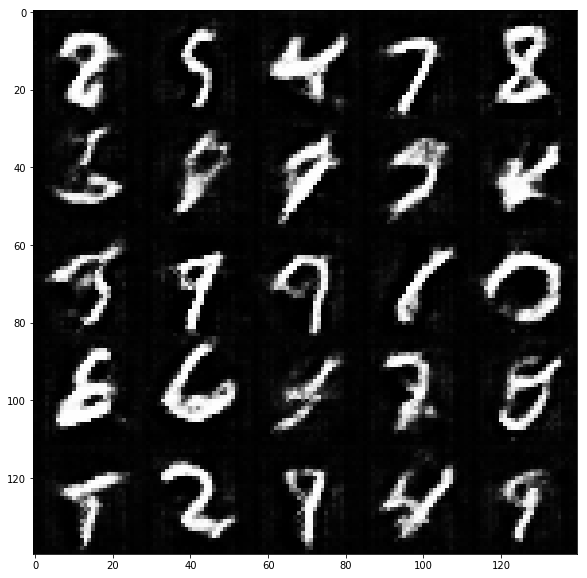

Epoch 1/2... Discriminator Loss: 1.3684... Generator Loss: 0.9356
Epoch 1/2... Discriminator Loss: 1.4099... Generator Loss: 0.6225
Epoch 1/2... Discriminator Loss: 1.3587... Generator Loss: 0.8249
Epoch 1/2... Discriminator Loss: 1.4474... Generator Loss: 0.4167
Epoch 1/2... Discriminator Loss: 1.3816... Generator Loss: 0.6683
Epoch 1/2... Discriminator Loss: 1.3947... Generator Loss: 0.4684
Epoch 1/2... Discriminator Loss: 1.3655... Generator Loss: 0.7179
Epoch 1/2... Discriminator Loss: 1.2212... Generator Loss: 0.7182
Epoch 1/2... Discriminator Loss: 1.3181... Generator Loss: 0.5917
Epoch 1/2... Discriminator Loss: 1.3051... Generator Loss: 0.9577


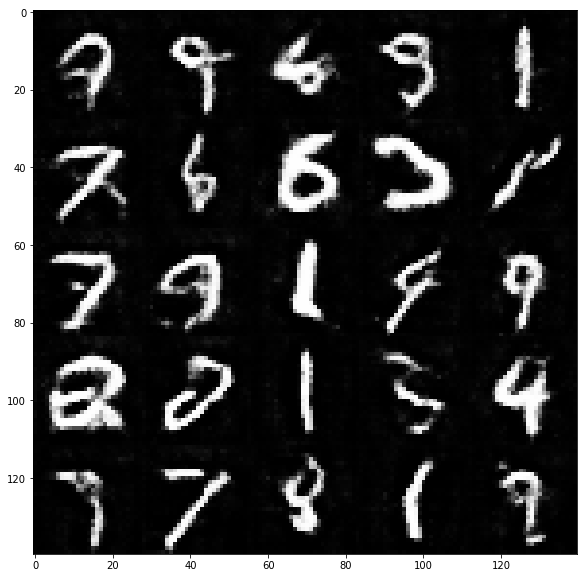

Epoch 1/2... Discriminator Loss: 1.3474... Generator Loss: 0.6918
Epoch 1/2... Discriminator Loss: 1.3129... Generator Loss: 0.6640
Epoch 1/2... Discriminator Loss: 1.2805... Generator Loss: 0.8676
Epoch 1/2... Discriminator Loss: 1.4533... Generator Loss: 0.9823
Epoch 1/2... Discriminator Loss: 1.3765... Generator Loss: 0.6499
Epoch 1/2... Discriminator Loss: 1.4211... Generator Loss: 0.5812
Epoch 2/2... Discriminator Loss: 1.4997... Generator Loss: 0.9364
Epoch 2/2... Discriminator Loss: 1.4619... Generator Loss: 0.4335
Epoch 2/2... Discriminator Loss: 1.4901... Generator Loss: 0.4168
Epoch 2/2... Discriminator Loss: 1.3258... Generator Loss: 0.6212


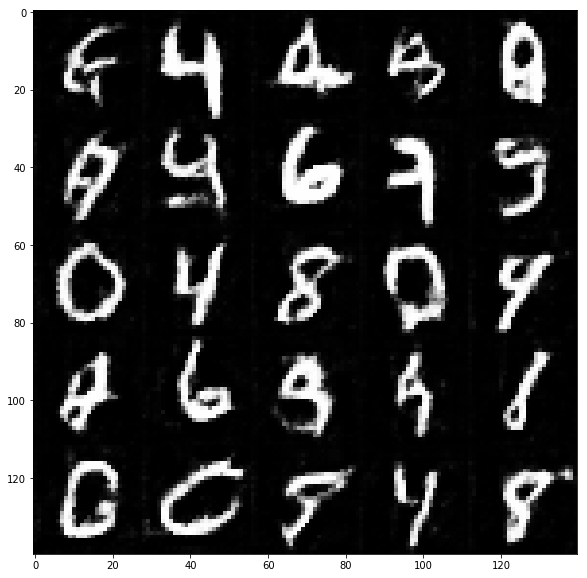

Epoch 2/2... Discriminator Loss: 1.2605... Generator Loss: 1.1323
Epoch 2/2... Discriminator Loss: 1.3286... Generator Loss: 0.5775
Epoch 2/2... Discriminator Loss: 1.3314... Generator Loss: 0.4994
Epoch 2/2... Discriminator Loss: 1.3244... Generator Loss: 0.5193
Epoch 2/2... Discriminator Loss: 1.2514... Generator Loss: 0.9930
Epoch 2/2... Discriminator Loss: 1.4234... Generator Loss: 0.9346
Epoch 2/2... Discriminator Loss: 1.5106... Generator Loss: 1.2543
Epoch 2/2... Discriminator Loss: 1.2253... Generator Loss: 0.6847
Epoch 2/2... Discriminator Loss: 1.2052... Generator Loss: 0.7113
Epoch 2/2... Discriminator Loss: 1.3673... Generator Loss: 0.5713


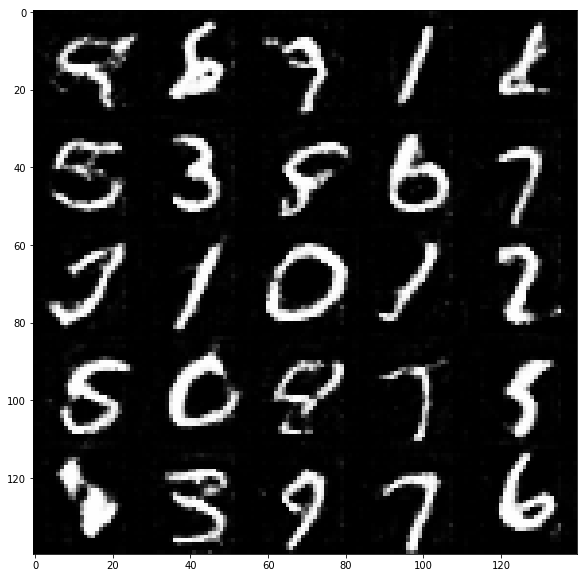

Epoch 2/2... Discriminator Loss: 1.4529... Generator Loss: 0.5483
Epoch 2/2... Discriminator Loss: 1.4484... Generator Loss: 0.7630
Epoch 2/2... Discriminator Loss: 1.3160... Generator Loss: 0.6997
Epoch 2/2... Discriminator Loss: 1.3184... Generator Loss: 0.5238
Epoch 2/2... Discriminator Loss: 1.2654... Generator Loss: 0.7790
Epoch 2/2... Discriminator Loss: 1.5446... Generator Loss: 0.4192
Epoch 2/2... Discriminator Loss: 1.2944... Generator Loss: 0.7796
Epoch 2/2... Discriminator Loss: 1.2605... Generator Loss: 0.6677
Epoch 2/2... Discriminator Loss: 1.4970... Generator Loss: 0.8101
Epoch 2/2... Discriminator Loss: 1.3368... Generator Loss: 0.6056


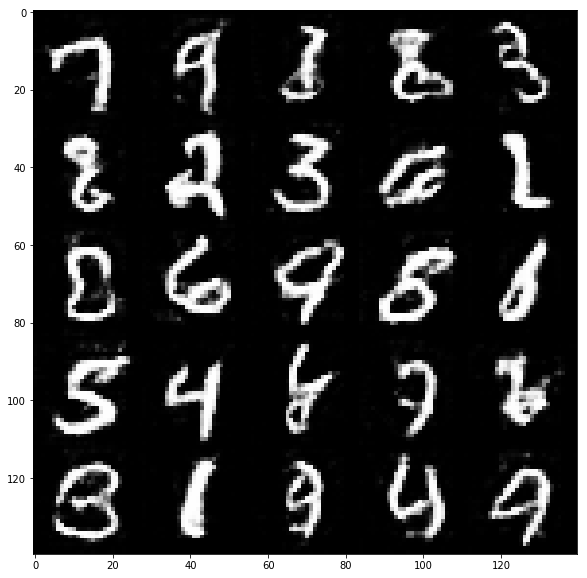

Epoch 2/2... Discriminator Loss: 1.2742... Generator Loss: 0.6357
Epoch 2/2... Discriminator Loss: 1.4964... Generator Loss: 0.3893
Epoch 2/2... Discriminator Loss: 1.2493... Generator Loss: 0.6357
Epoch 2/2... Discriminator Loss: 1.3945... Generator Loss: 0.8995
Epoch 2/2... Discriminator Loss: 1.1943... Generator Loss: 0.7478
Epoch 2/2... Discriminator Loss: 1.2920... Generator Loss: 0.5872
Epoch 2/2... Discriminator Loss: 1.4335... Generator Loss: 1.1218
Epoch 2/2... Discriminator Loss: 1.2176... Generator Loss: 0.6609
Epoch 2/2... Discriminator Loss: 1.2176... Generator Loss: 0.8522
Epoch 2/2... Discriminator Loss: 1.3990... Generator Loss: 0.5060


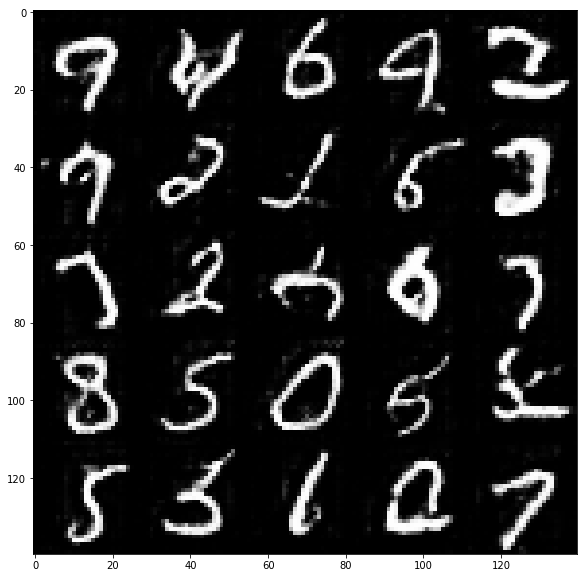

Epoch 2/2... Discriminator Loss: 1.1847... Generator Loss: 0.8102
Epoch 2/2... Discriminator Loss: 1.3719... Generator Loss: 0.6739
Epoch 2/2... Discriminator Loss: 1.3291... Generator Loss: 0.6920
Epoch 2/2... Discriminator Loss: 1.3640... Generator Loss: 0.5427
Epoch 2/2... Discriminator Loss: 1.2450... Generator Loss: 0.5926
Epoch 2/2... Discriminator Loss: 1.2059... Generator Loss: 0.9053
Epoch 2/2... Discriminator Loss: 1.3072... Generator Loss: 0.7354
Epoch 2/2... Discriminator Loss: 1.3707... Generator Loss: 0.6423
Epoch 2/2... Discriminator Loss: 1.3771... Generator Loss: 0.5930
Epoch 2/2... Discriminator Loss: 1.3361... Generator Loss: 0.6447


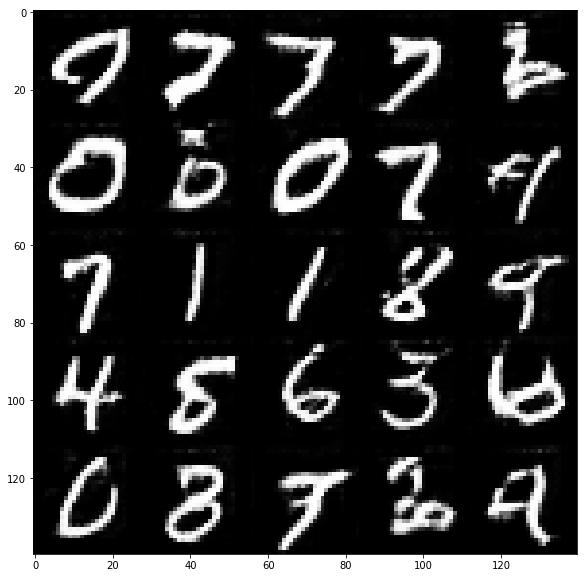

Epoch 2/2... Discriminator Loss: 1.2090... Generator Loss: 0.6822
Epoch 2/2... Discriminator Loss: 1.4102... Generator Loss: 0.4561
Epoch 2/2... Discriminator Loss: 1.2477... Generator Loss: 0.6104


In [15]:
batch_size = 64
z_dim = 150
learning_rate = 0.0003
beta1 = 0.45


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/3... Discriminator Loss: 0.0187... Generator Loss: 4.4555
Epoch 1/3... Discriminator Loss: 4.8336... Generator Loss: 0.0378
Epoch 1/3... Discriminator Loss: 1.2464... Generator Loss: 0.9506
Epoch 1/3... Discriminator Loss: 1.1272... Generator Loss: 1.3181
Epoch 1/3... Discriminator Loss: 1.2623... Generator Loss: 0.6007
Epoch 1/3... Discriminator Loss: 1.4657... Generator Loss: 0.5501
Epoch 1/3... Discriminator Loss: 1.5788... Generator Loss: 3.3130
Epoch 1/3... Discriminator Loss: 1.4863... Generator Loss: 0.4898
Epoch 1/3... Discriminator Loss: 1.1485... Generator Loss: 0.8675
Epoch 1/3... Discriminator Loss: 1.4129... Generator Loss: 0.8514


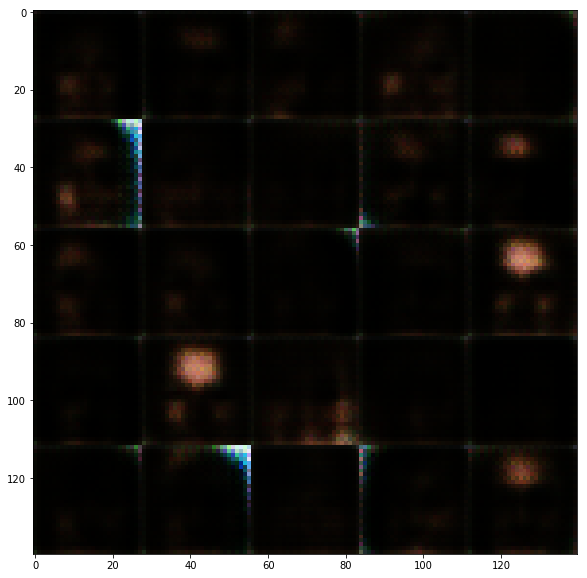

Epoch 1/3... Discriminator Loss: 1.3532... Generator Loss: 0.9497
Epoch 1/3... Discriminator Loss: 1.1254... Generator Loss: 1.0410
Epoch 1/3... Discriminator Loss: 0.9344... Generator Loss: 1.4370
Epoch 1/3... Discriminator Loss: 1.1076... Generator Loss: 1.0298
Epoch 1/3... Discriminator Loss: 1.3841... Generator Loss: 0.6704
Epoch 1/3... Discriminator Loss: 1.0780... Generator Loss: 1.2009
Epoch 1/3... Discriminator Loss: 1.5211... Generator Loss: 0.6736
Epoch 1/3... Discriminator Loss: 1.7372... Generator Loss: 0.3588
Epoch 1/3... Discriminator Loss: 1.5882... Generator Loss: 0.4864
Epoch 1/3... Discriminator Loss: 1.5386... Generator Loss: 0.5826


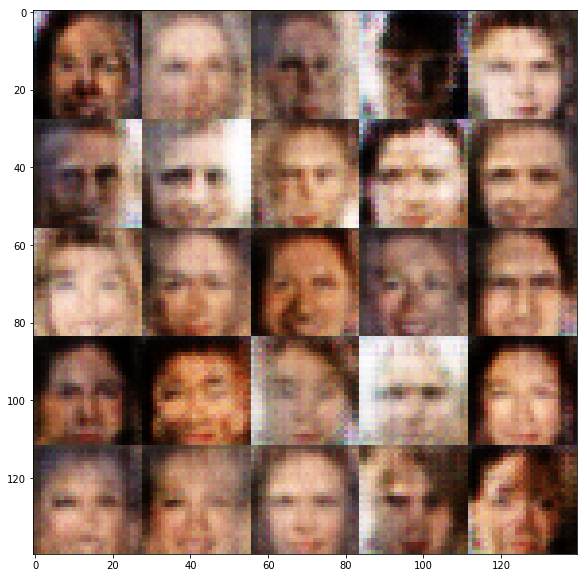

Epoch 1/3... Discriminator Loss: 1.5529... Generator Loss: 0.5923
Epoch 1/3... Discriminator Loss: 1.4571... Generator Loss: 0.6310
Epoch 1/3... Discriminator Loss: 1.5322... Generator Loss: 0.5118
Epoch 1/3... Discriminator Loss: 1.4316... Generator Loss: 0.6565
Epoch 1/3... Discriminator Loss: 1.5661... Generator Loss: 0.6152
Epoch 1/3... Discriminator Loss: 1.6366... Generator Loss: 0.5178
Epoch 1/3... Discriminator Loss: 1.3928... Generator Loss: 0.6614
Epoch 1/3... Discriminator Loss: 1.3992... Generator Loss: 0.7099
Epoch 1/3... Discriminator Loss: 1.4842... Generator Loss: 0.6741
Epoch 1/3... Discriminator Loss: 1.4887... Generator Loss: 0.7060


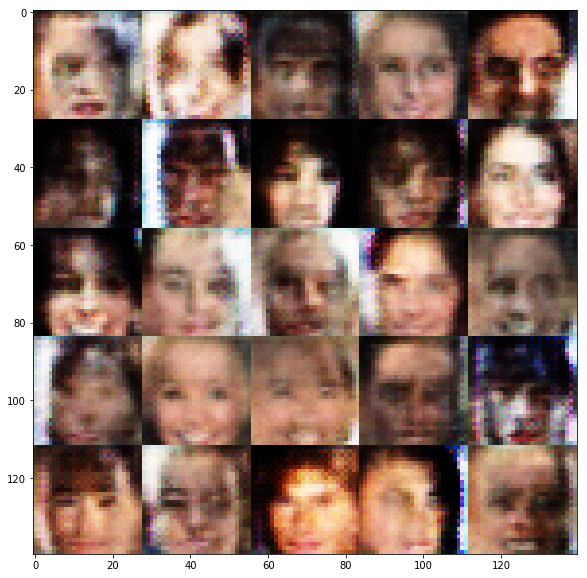

Epoch 1/3... Discriminator Loss: 1.4158... Generator Loss: 0.6253
Epoch 1/3... Discriminator Loss: 1.4756... Generator Loss: 0.7046
Epoch 1/3... Discriminator Loss: 1.3950... Generator Loss: 0.6191
Epoch 1/3... Discriminator Loss: 1.4549... Generator Loss: 0.6707
Epoch 1/3... Discriminator Loss: 1.4560... Generator Loss: 0.6965
Epoch 1/3... Discriminator Loss: 1.3865... Generator Loss: 0.6272
Epoch 1/3... Discriminator Loss: 1.4335... Generator Loss: 0.6637
Epoch 1/3... Discriminator Loss: 1.4167... Generator Loss: 0.5982
Epoch 1/3... Discriminator Loss: 1.4517... Generator Loss: 0.6654
Epoch 1/3... Discriminator Loss: 1.3973... Generator Loss: 0.6313


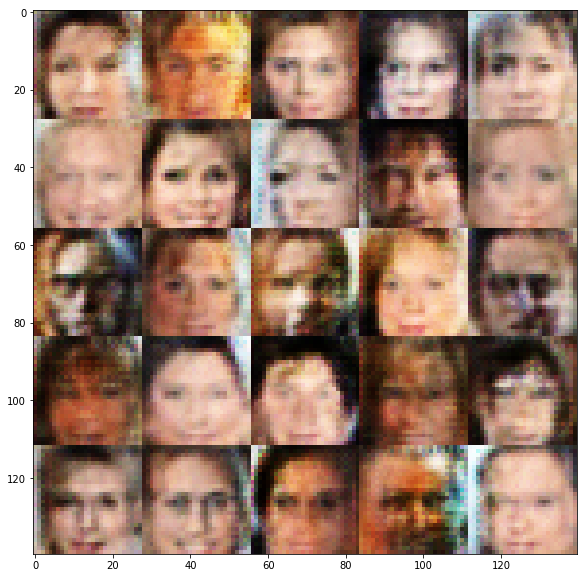

Epoch 1/3... Discriminator Loss: 1.4823... Generator Loss: 0.7070
Epoch 1/3... Discriminator Loss: 1.4643... Generator Loss: 0.6866
Epoch 1/3... Discriminator Loss: 1.4388... Generator Loss: 0.6024
Epoch 1/3... Discriminator Loss: 1.4822... Generator Loss: 0.6476
Epoch 1/3... Discriminator Loss: 1.5108... Generator Loss: 0.7048
Epoch 1/3... Discriminator Loss: 1.4414... Generator Loss: 0.6558
Epoch 1/3... Discriminator Loss: 1.4479... Generator Loss: 0.6406
Epoch 1/3... Discriminator Loss: 1.4718... Generator Loss: 0.6157
Epoch 1/3... Discriminator Loss: 1.3478... Generator Loss: 0.6954
Epoch 1/3... Discriminator Loss: 1.4840... Generator Loss: 0.6666


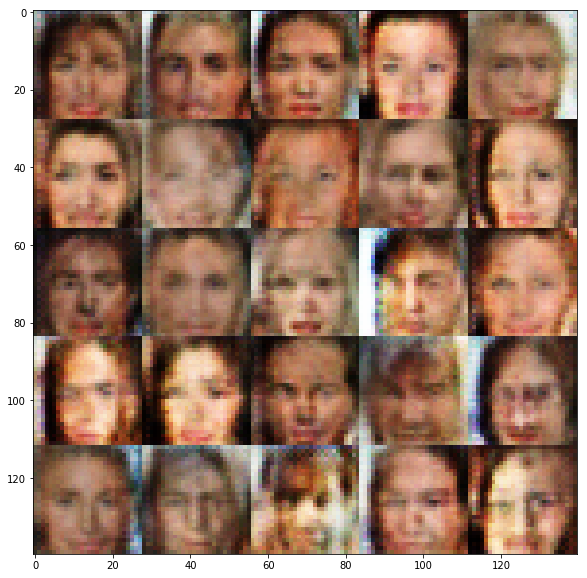

Epoch 1/3... Discriminator Loss: 1.4642... Generator Loss: 0.6356
Epoch 1/3... Discriminator Loss: 1.4682... Generator Loss: 0.7476
Epoch 1/3... Discriminator Loss: 1.4518... Generator Loss: 0.7044
Epoch 1/3... Discriminator Loss: 1.4362... Generator Loss: 0.6296
Epoch 1/3... Discriminator Loss: 1.4784... Generator Loss: 0.6506
Epoch 1/3... Discriminator Loss: 1.4331... Generator Loss: 0.6693
Epoch 1/3... Discriminator Loss: 1.4292... Generator Loss: 0.6086
Epoch 1/3... Discriminator Loss: 1.4642... Generator Loss: 0.6563
Epoch 1/3... Discriminator Loss: 1.4310... Generator Loss: 0.6911
Epoch 1/3... Discriminator Loss: 1.4611... Generator Loss: 0.6214


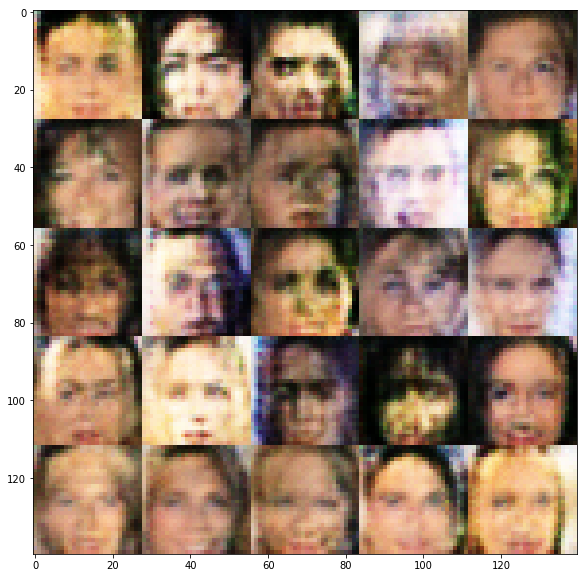

Epoch 1/3... Discriminator Loss: 1.3866... Generator Loss: 0.7041
Epoch 1/3... Discriminator Loss: 1.4194... Generator Loss: 0.6066
Epoch 1/3... Discriminator Loss: 1.3921... Generator Loss: 0.6456
Epoch 1/3... Discriminator Loss: 1.4366... Generator Loss: 0.7103
Epoch 1/3... Discriminator Loss: 1.4146... Generator Loss: 0.6675
Epoch 1/3... Discriminator Loss: 1.4406... Generator Loss: 0.7022
Epoch 1/3... Discriminator Loss: 1.3902... Generator Loss: 0.6686
Epoch 1/3... Discriminator Loss: 1.3937... Generator Loss: 0.6163
Epoch 1/3... Discriminator Loss: 1.4342... Generator Loss: 0.7776
Epoch 1/3... Discriminator Loss: 1.4187... Generator Loss: 0.7091


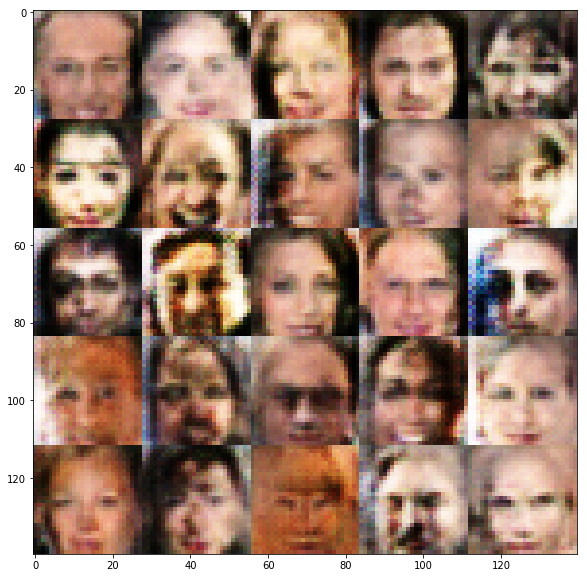

Epoch 1/3... Discriminator Loss: 1.4196... Generator Loss: 0.7156
Epoch 1/3... Discriminator Loss: 1.4728... Generator Loss: 0.6069
Epoch 1/3... Discriminator Loss: 1.3763... Generator Loss: 0.6646
Epoch 1/3... Discriminator Loss: 1.4318... Generator Loss: 0.6584
Epoch 1/3... Discriminator Loss: 1.3932... Generator Loss: 0.7084
Epoch 1/3... Discriminator Loss: 1.4196... Generator Loss: 0.6866
Epoch 1/3... Discriminator Loss: 1.4486... Generator Loss: 0.7678
Epoch 1/3... Discriminator Loss: 1.4107... Generator Loss: 0.7028
Epoch 1/3... Discriminator Loss: 1.4451... Generator Loss: 0.5765
Epoch 1/3... Discriminator Loss: 1.4220... Generator Loss: 0.6714


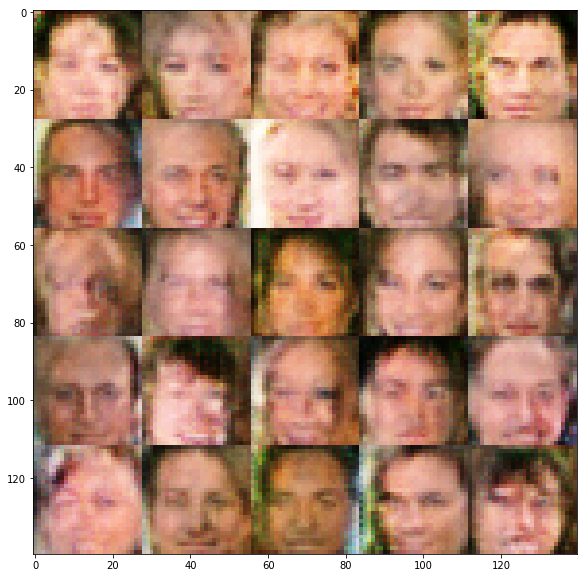

Epoch 1/3... Discriminator Loss: 1.3704... Generator Loss: 0.6553
Epoch 1/3... Discriminator Loss: 1.4211... Generator Loss: 0.6694
Epoch 1/3... Discriminator Loss: 1.3815... Generator Loss: 0.6785
Epoch 1/3... Discriminator Loss: 1.4256... Generator Loss: 0.6308
Epoch 1/3... Discriminator Loss: 1.3429... Generator Loss: 0.8778
Epoch 1/3... Discriminator Loss: 1.4923... Generator Loss: 0.6837
Epoch 1/3... Discriminator Loss: 1.3491... Generator Loss: 0.7047
Epoch 1/3... Discriminator Loss: 1.4977... Generator Loss: 0.6022
Epoch 1/3... Discriminator Loss: 1.4332... Generator Loss: 0.6558
Epoch 1/3... Discriminator Loss: 1.3697... Generator Loss: 0.6916


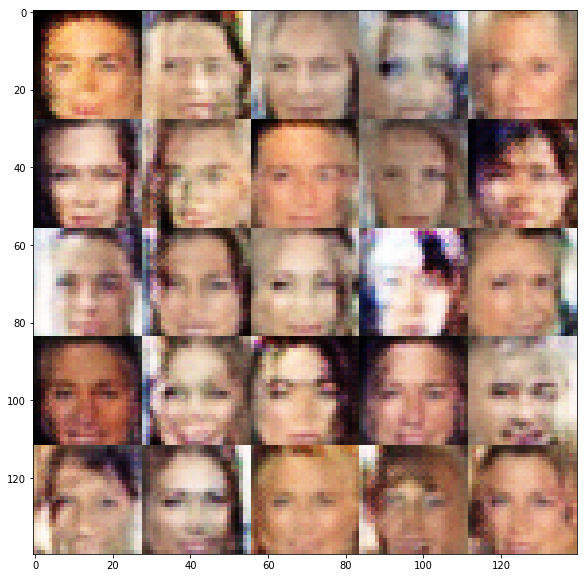

Epoch 1/3... Discriminator Loss: 1.3688... Generator Loss: 0.6665
Epoch 1/3... Discriminator Loss: 1.2942... Generator Loss: 0.7407
Epoch 1/3... Discriminator Loss: 1.0936... Generator Loss: 1.4932
Epoch 1/3... Discriminator Loss: 1.4129... Generator Loss: 0.5857
Epoch 1/3... Discriminator Loss: 1.5995... Generator Loss: 0.5699
Epoch 1/3... Discriminator Loss: 1.4489... Generator Loss: 0.6508
Epoch 1/3... Discriminator Loss: 1.3450... Generator Loss: 0.7271
Epoch 1/3... Discriminator Loss: 1.4150... Generator Loss: 0.6123
Epoch 1/3... Discriminator Loss: 1.3923... Generator Loss: 0.5655
Epoch 1/3... Discriminator Loss: 1.2080... Generator Loss: 0.7636


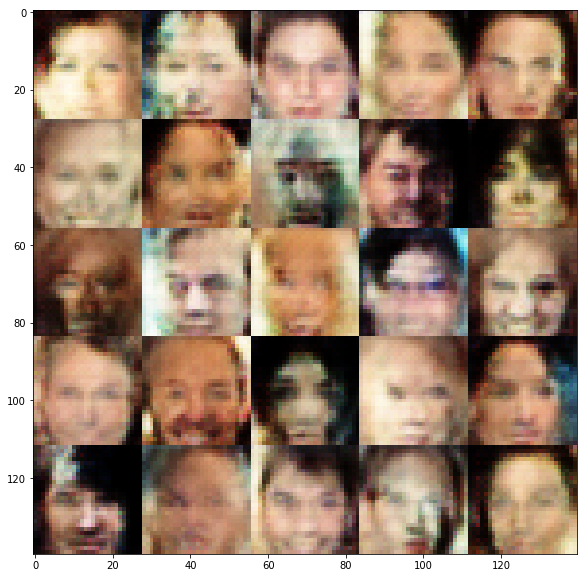

Epoch 1/3... Discriminator Loss: 1.3521... Generator Loss: 0.7657
Epoch 1/3... Discriminator Loss: 1.2844... Generator Loss: 0.6889
Epoch 1/3... Discriminator Loss: 1.2780... Generator Loss: 0.5976
Epoch 1/3... Discriminator Loss: 1.4619... Generator Loss: 0.7119
Epoch 1/3... Discriminator Loss: 1.3934... Generator Loss: 0.6626
Epoch 1/3... Discriminator Loss: 1.4328... Generator Loss: 0.5678
Epoch 1/3... Discriminator Loss: 1.3822... Generator Loss: 0.6386
Epoch 1/3... Discriminator Loss: 1.4373... Generator Loss: 0.6095
Epoch 1/3... Discriminator Loss: 1.4196... Generator Loss: 0.7315
Epoch 1/3... Discriminator Loss: 1.5696... Generator Loss: 0.6116


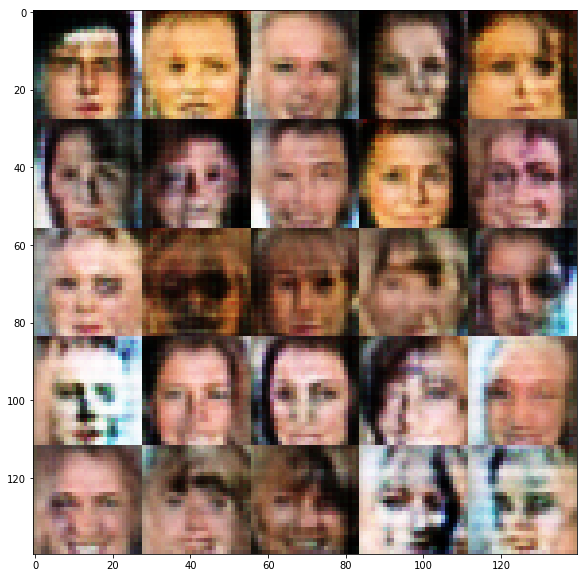

Epoch 1/3... Discriminator Loss: 1.3835... Generator Loss: 0.6258
Epoch 1/3... Discriminator Loss: 1.3610... Generator Loss: 0.6420
Epoch 1/3... Discriminator Loss: 1.4183... Generator Loss: 0.6587
Epoch 1/3... Discriminator Loss: 1.3913... Generator Loss: 0.6113
Epoch 1/3... Discriminator Loss: 1.4248... Generator Loss: 0.5940
Epoch 1/3... Discriminator Loss: 1.3836... Generator Loss: 0.6388
Epoch 1/3... Discriminator Loss: 1.3298... Generator Loss: 0.5904
Epoch 1/3... Discriminator Loss: 1.3645... Generator Loss: 0.5973
Epoch 1/3... Discriminator Loss: 1.4318... Generator Loss: 0.6425
Epoch 1/3... Discriminator Loss: 1.4612... Generator Loss: 0.5400


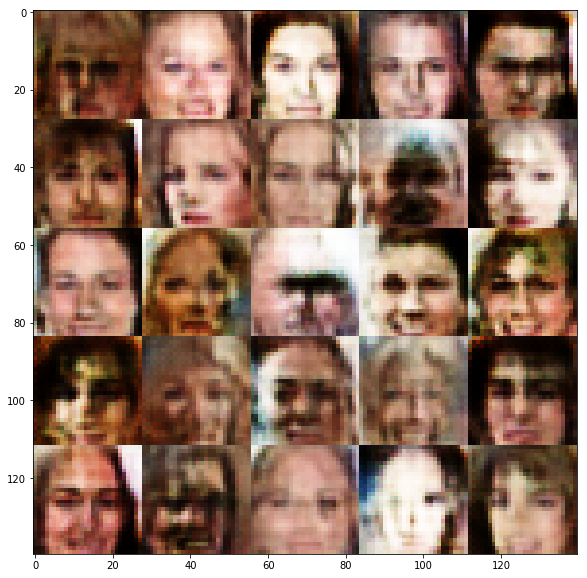

Epoch 1/3... Discriminator Loss: 1.1871... Generator Loss: 0.7982
Epoch 1/3... Discriminator Loss: 1.3134... Generator Loss: 0.6356
Epoch 1/3... Discriminator Loss: 1.2929... Generator Loss: 0.7716
Epoch 1/3... Discriminator Loss: 1.4026... Generator Loss: 0.6403
Epoch 1/3... Discriminator Loss: 1.2410... Generator Loss: 0.6949
Epoch 1/3... Discriminator Loss: 1.2795... Generator Loss: 0.7023
Epoch 1/3... Discriminator Loss: 1.3476... Generator Loss: 0.8081
Epoch 1/3... Discriminator Loss: 1.4208... Generator Loss: 0.5959
Epoch 1/3... Discriminator Loss: 1.3908... Generator Loss: 0.6550
Epoch 1/3... Discriminator Loss: 1.3282... Generator Loss: 0.6079


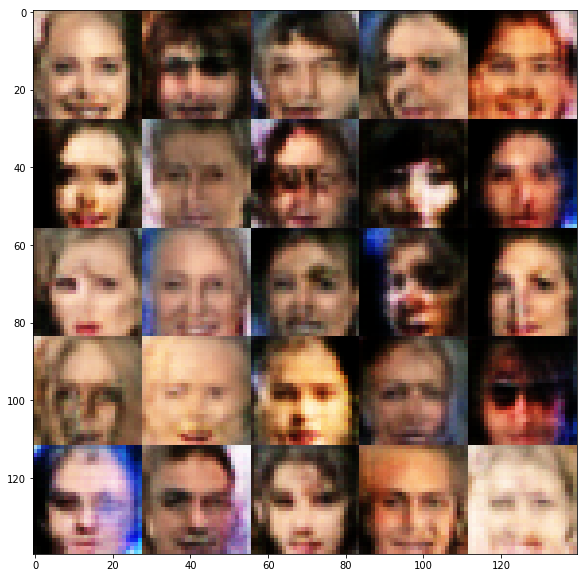

Epoch 1/3... Discriminator Loss: 1.4775... Generator Loss: 0.6670
Epoch 1/3... Discriminator Loss: 1.4181... Generator Loss: 0.6159
Epoch 1/3... Discriminator Loss: 1.3767... Generator Loss: 0.7186
Epoch 1/3... Discriminator Loss: 1.3635... Generator Loss: 0.6036
Epoch 1/3... Discriminator Loss: 1.2800... Generator Loss: 0.7762
Epoch 1/3... Discriminator Loss: 1.3864... Generator Loss: 0.6489
Epoch 1/3... Discriminator Loss: 1.3947... Generator Loss: 0.6436
Epoch 1/3... Discriminator Loss: 1.4749... Generator Loss: 0.6400
Epoch 1/3... Discriminator Loss: 1.4606... Generator Loss: 0.6306
Epoch 1/3... Discriminator Loss: 1.4432... Generator Loss: 0.5620


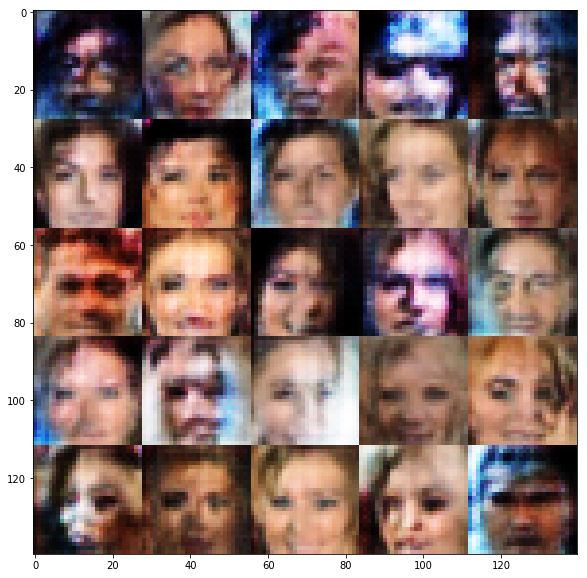

Epoch 1/3... Discriminator Loss: 1.3669... Generator Loss: 0.6410
Epoch 1/3... Discriminator Loss: 1.3626... Generator Loss: 0.9703
Epoch 1/3... Discriminator Loss: 1.3415... Generator Loss: 0.7519
Epoch 1/3... Discriminator Loss: 1.4562... Generator Loss: 0.5667
Epoch 1/3... Discriminator Loss: 1.4245... Generator Loss: 0.7118
Epoch 1/3... Discriminator Loss: 1.3860... Generator Loss: 0.5961
Epoch 1/3... Discriminator Loss: 1.4599... Generator Loss: 0.7501
Epoch 1/3... Discriminator Loss: 1.3933... Generator Loss: 0.6953
Epoch 1/3... Discriminator Loss: 1.3466... Generator Loss: 0.8637
Epoch 1/3... Discriminator Loss: 1.3701... Generator Loss: 0.7010


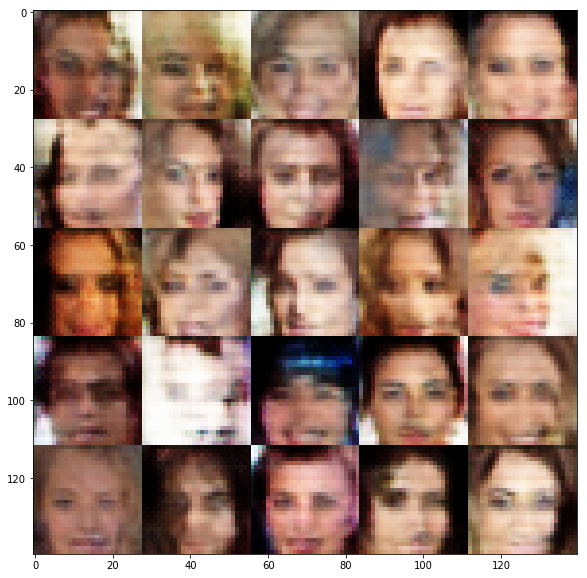

Epoch 1/3... Discriminator Loss: 1.3128... Generator Loss: 0.6984
Epoch 1/3... Discriminator Loss: 1.5039... Generator Loss: 0.7318
Epoch 1/3... Discriminator Loss: 1.3208... Generator Loss: 0.6606
Epoch 1/3... Discriminator Loss: 1.4152... Generator Loss: 0.6401
Epoch 1/3... Discriminator Loss: 1.2764... Generator Loss: 0.6556
Epoch 1/3... Discriminator Loss: 1.4558... Generator Loss: 0.5787
Epoch 1/3... Discriminator Loss: 1.4914... Generator Loss: 0.5304
Epoch 1/3... Discriminator Loss: 1.3893... Generator Loss: 0.8104
Epoch 2/3... Discriminator Loss: 1.4150... Generator Loss: 0.6246
Epoch 2/3... Discriminator Loss: 1.3786... Generator Loss: 0.6226


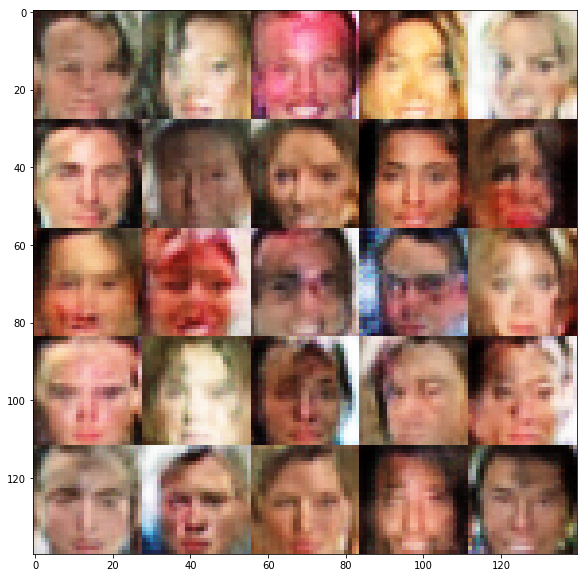

Epoch 2/3... Discriminator Loss: 1.3963... Generator Loss: 0.5896
Epoch 2/3... Discriminator Loss: 1.5028... Generator Loss: 0.6150
Epoch 2/3... Discriminator Loss: 1.4114... Generator Loss: 0.6487
Epoch 2/3... Discriminator Loss: 1.3751... Generator Loss: 0.5653
Epoch 2/3... Discriminator Loss: 1.4523... Generator Loss: 0.6611
Epoch 2/3... Discriminator Loss: 1.4434... Generator Loss: 0.8066
Epoch 2/3... Discriminator Loss: 1.4514... Generator Loss: 0.6239
Epoch 2/3... Discriminator Loss: 1.4024... Generator Loss: 0.6920
Epoch 2/3... Discriminator Loss: 1.4409... Generator Loss: 0.6438
Epoch 2/3... Discriminator Loss: 1.4677... Generator Loss: 0.6032


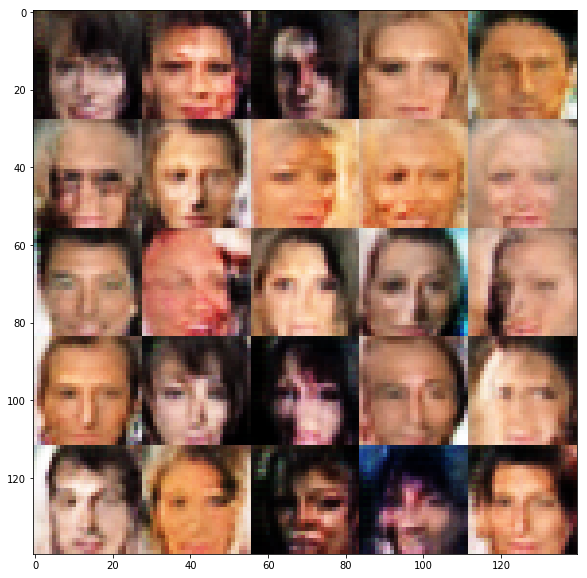

Epoch 2/3... Discriminator Loss: 1.4158... Generator Loss: 0.6739
Epoch 2/3... Discriminator Loss: 1.4441... Generator Loss: 0.6335
Epoch 2/3... Discriminator Loss: 1.3530... Generator Loss: 0.7898
Epoch 2/3... Discriminator Loss: 1.2317... Generator Loss: 0.8899
Epoch 2/3... Discriminator Loss: 1.3007... Generator Loss: 0.7010
Epoch 2/3... Discriminator Loss: 1.3808... Generator Loss: 0.7272
Epoch 2/3... Discriminator Loss: 1.4185... Generator Loss: 0.6027
Epoch 2/3... Discriminator Loss: 1.4281... Generator Loss: 0.6621
Epoch 2/3... Discriminator Loss: 1.4035... Generator Loss: 0.6654
Epoch 2/3... Discriminator Loss: 1.5019... Generator Loss: 0.6791


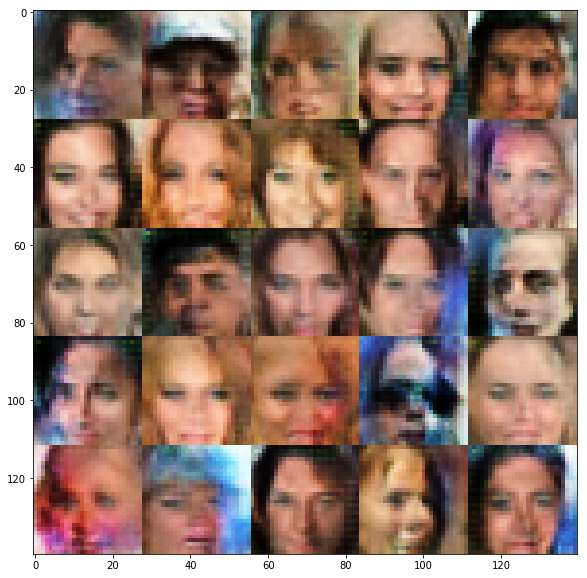

Epoch 2/3... Discriminator Loss: 1.3764... Generator Loss: 0.5950
Epoch 2/3... Discriminator Loss: 1.3956... Generator Loss: 0.6785
Epoch 2/3... Discriminator Loss: 1.3223... Generator Loss: 0.7454
Epoch 2/3... Discriminator Loss: 1.4971... Generator Loss: 0.6535
Epoch 2/3... Discriminator Loss: 1.3566... Generator Loss: 0.6154
Epoch 2/3... Discriminator Loss: 1.4160... Generator Loss: 0.6641
Epoch 2/3... Discriminator Loss: 1.4403... Generator Loss: 0.6198
Epoch 2/3... Discriminator Loss: 1.3460... Generator Loss: 0.7108
Epoch 2/3... Discriminator Loss: 1.4752... Generator Loss: 0.6108
Epoch 2/3... Discriminator Loss: 1.4752... Generator Loss: 0.6579


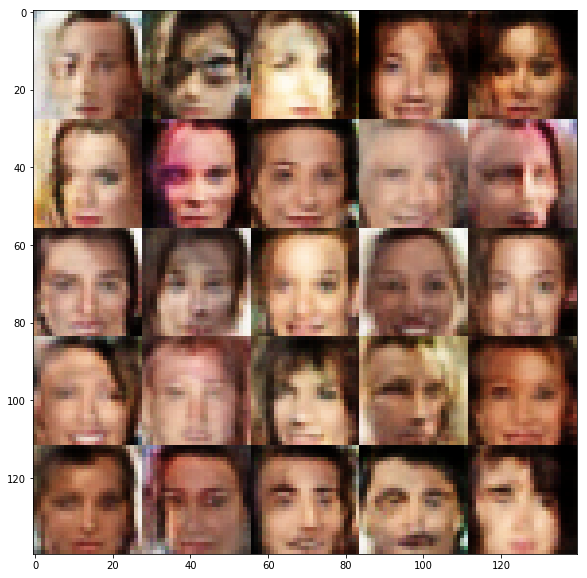

Epoch 2/3... Discriminator Loss: 1.3909... Generator Loss: 0.6941
Epoch 2/3... Discriminator Loss: 1.4258... Generator Loss: 0.6802
Epoch 2/3... Discriminator Loss: 1.4267... Generator Loss: 0.6760
Epoch 2/3... Discriminator Loss: 1.4094... Generator Loss: 0.6055
Epoch 2/3... Discriminator Loss: 1.3857... Generator Loss: 0.6840
Epoch 2/3... Discriminator Loss: 1.3989... Generator Loss: 0.6673
Epoch 2/3... Discriminator Loss: 1.3827... Generator Loss: 0.5782
Epoch 2/3... Discriminator Loss: 1.3763... Generator Loss: 0.7168
Epoch 2/3... Discriminator Loss: 1.4394... Generator Loss: 0.6164
Epoch 2/3... Discriminator Loss: 1.3692... Generator Loss: 0.6054


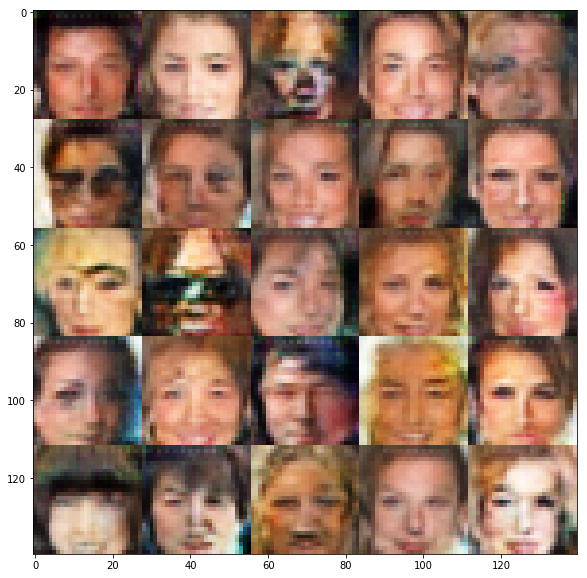

Epoch 2/3... Discriminator Loss: 1.4385... Generator Loss: 0.5755
Epoch 2/3... Discriminator Loss: 1.3400... Generator Loss: 0.8199
Epoch 2/3... Discriminator Loss: 1.3888... Generator Loss: 0.6664
Epoch 2/3... Discriminator Loss: 1.3417... Generator Loss: 0.6671
Epoch 2/3... Discriminator Loss: 1.4281... Generator Loss: 0.7009
Epoch 2/3... Discriminator Loss: 1.4893... Generator Loss: 0.6122
Epoch 2/3... Discriminator Loss: 1.3974... Generator Loss: 0.6713
Epoch 2/3... Discriminator Loss: 1.4354... Generator Loss: 0.7330
Epoch 2/3... Discriminator Loss: 1.4306... Generator Loss: 0.5801
Epoch 2/3... Discriminator Loss: 1.3638... Generator Loss: 0.6591


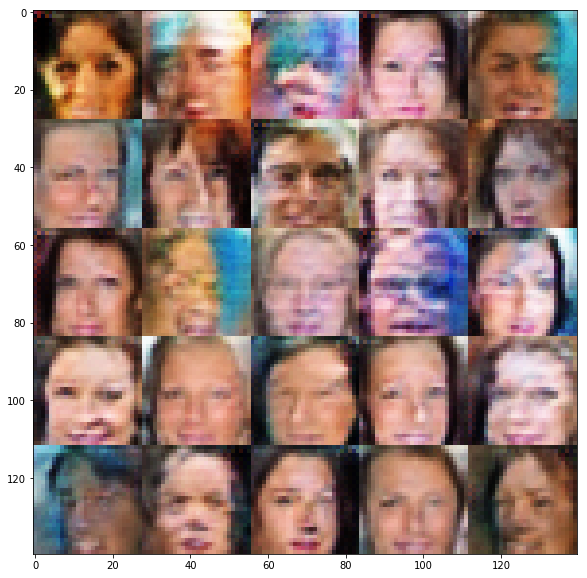

Epoch 2/3... Discriminator Loss: 1.4623... Generator Loss: 0.5594
Epoch 2/3... Discriminator Loss: 1.4006... Generator Loss: 0.7462
Epoch 2/3... Discriminator Loss: 1.4035... Generator Loss: 0.6382
Epoch 2/3... Discriminator Loss: 1.4548... Generator Loss: 0.7367
Epoch 2/3... Discriminator Loss: 1.3945... Generator Loss: 0.7581
Epoch 2/3... Discriminator Loss: 1.4631... Generator Loss: 0.5852
Epoch 2/3... Discriminator Loss: 1.4447... Generator Loss: 0.6810
Epoch 2/3... Discriminator Loss: 1.3383... Generator Loss: 0.6704
Epoch 2/3... Discriminator Loss: 1.5633... Generator Loss: 0.5516
Epoch 2/3... Discriminator Loss: 1.4388... Generator Loss: 0.6586


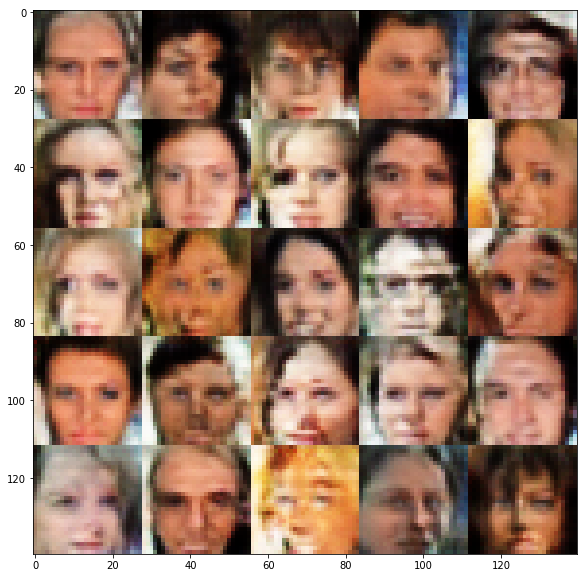

Epoch 2/3... Discriminator Loss: 1.3765... Generator Loss: 0.7497
Epoch 2/3... Discriminator Loss: 1.4109... Generator Loss: 0.5791
Epoch 2/3... Discriminator Loss: 1.4048... Generator Loss: 0.6945
Epoch 2/3... Discriminator Loss: 1.4516... Generator Loss: 0.7211
Epoch 2/3... Discriminator Loss: 1.5105... Generator Loss: 0.6620
Epoch 2/3... Discriminator Loss: 1.4340... Generator Loss: 0.6969
Epoch 2/3... Discriminator Loss: 1.3664... Generator Loss: 0.6732
Epoch 2/3... Discriminator Loss: 1.4048... Generator Loss: 0.6459
Epoch 2/3... Discriminator Loss: 1.3780... Generator Loss: 0.6430
Epoch 2/3... Discriminator Loss: 1.4365... Generator Loss: 0.6098


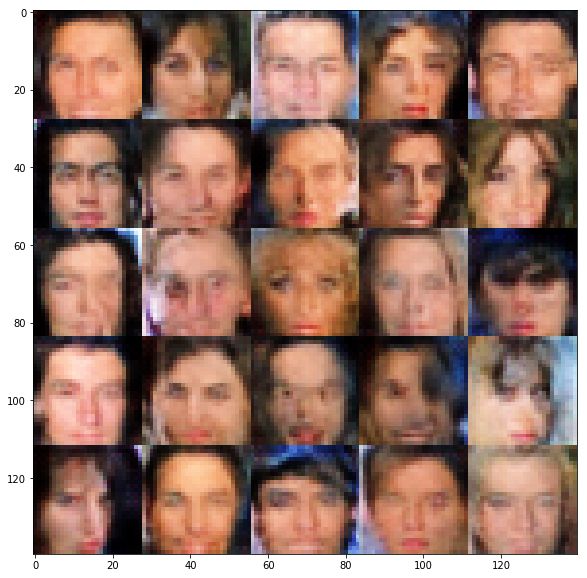

Epoch 2/3... Discriminator Loss: 1.3126... Generator Loss: 0.7312
Epoch 2/3... Discriminator Loss: 1.4103... Generator Loss: 0.6820
Epoch 2/3... Discriminator Loss: 1.2984... Generator Loss: 0.7273
Epoch 2/3... Discriminator Loss: 1.4230... Generator Loss: 0.6313
Epoch 2/3... Discriminator Loss: 1.4217... Generator Loss: 0.5646
Epoch 2/3... Discriminator Loss: 1.3623... Generator Loss: 0.6972
Epoch 2/3... Discriminator Loss: 1.4787... Generator Loss: 0.6284
Epoch 2/3... Discriminator Loss: 1.4219... Generator Loss: 0.7246
Epoch 2/3... Discriminator Loss: 1.3963... Generator Loss: 0.7823
Epoch 2/3... Discriminator Loss: 1.3895... Generator Loss: 0.7293


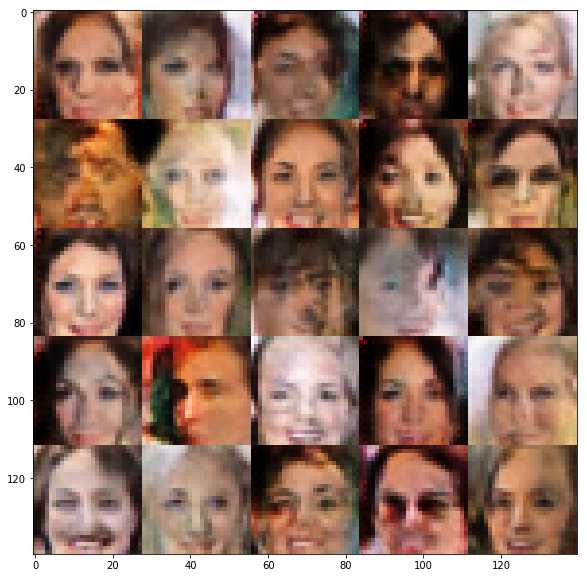

Epoch 2/3... Discriminator Loss: 1.2784... Generator Loss: 0.7863
Epoch 2/3... Discriminator Loss: 1.4993... Generator Loss: 0.5931
Epoch 2/3... Discriminator Loss: 1.4329... Generator Loss: 0.6248
Epoch 2/3... Discriminator Loss: 1.3727... Generator Loss: 0.6617
Epoch 2/3... Discriminator Loss: 1.4325... Generator Loss: 0.5834
Epoch 2/3... Discriminator Loss: 1.4340... Generator Loss: 0.6642
Epoch 2/3... Discriminator Loss: 1.4855... Generator Loss: 0.6168
Epoch 2/3... Discriminator Loss: 1.4374... Generator Loss: 0.6621
Epoch 2/3... Discriminator Loss: 1.4091... Generator Loss: 0.6419
Epoch 2/3... Discriminator Loss: 1.3983... Generator Loss: 0.6847


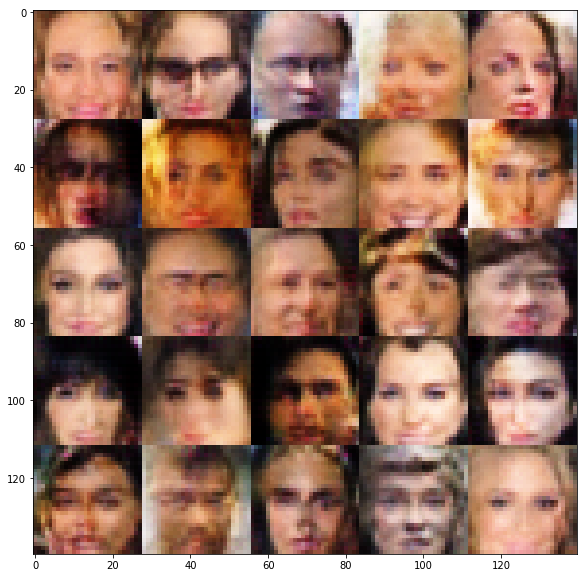

Epoch 2/3... Discriminator Loss: 1.3978... Generator Loss: 0.6693
Epoch 2/3... Discriminator Loss: 1.3614... Generator Loss: 0.6344
Epoch 2/3... Discriminator Loss: 1.3772... Generator Loss: 0.6621
Epoch 2/3... Discriminator Loss: 1.4242... Generator Loss: 0.6693
Epoch 2/3... Discriminator Loss: 1.4022... Generator Loss: 0.6794
Epoch 2/3... Discriminator Loss: 1.3649... Generator Loss: 0.6790
Epoch 2/3... Discriminator Loss: 1.3454... Generator Loss: 0.8316
Epoch 2/3... Discriminator Loss: 1.3686... Generator Loss: 0.6136
Epoch 2/3... Discriminator Loss: 1.4447... Generator Loss: 0.6723
Epoch 2/3... Discriminator Loss: 1.4076... Generator Loss: 0.7198


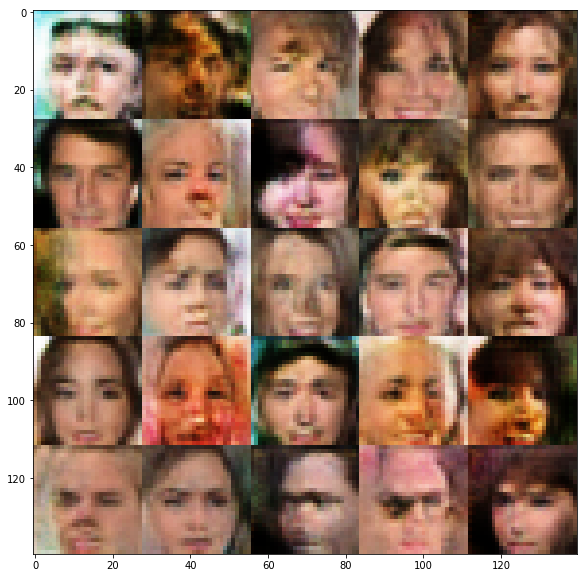

Epoch 2/3... Discriminator Loss: 1.5183... Generator Loss: 0.6403
Epoch 2/3... Discriminator Loss: 1.5051... Generator Loss: 0.4598
Epoch 2/3... Discriminator Loss: 1.4749... Generator Loss: 0.6562
Epoch 2/3... Discriminator Loss: 1.4132... Generator Loss: 0.6576
Epoch 2/3... Discriminator Loss: 1.3568... Generator Loss: 0.6750
Epoch 2/3... Discriminator Loss: 1.5264... Generator Loss: 0.6108
Epoch 2/3... Discriminator Loss: 1.4252... Generator Loss: 0.6599
Epoch 2/3... Discriminator Loss: 1.4021... Generator Loss: 0.6715
Epoch 2/3... Discriminator Loss: 1.4210... Generator Loss: 0.6193
Epoch 2/3... Discriminator Loss: 1.4534... Generator Loss: 0.6726


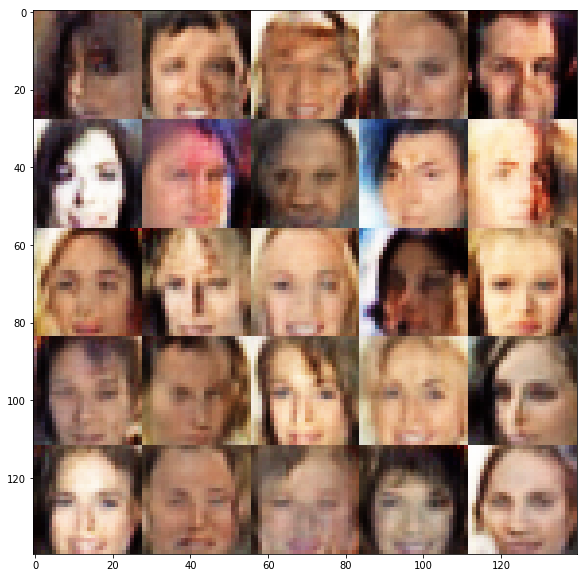

Epoch 2/3... Discriminator Loss: 1.3899... Generator Loss: 0.6736
Epoch 2/3... Discriminator Loss: 1.4487... Generator Loss: 0.6261
Epoch 2/3... Discriminator Loss: 1.3891... Generator Loss: 0.6825
Epoch 2/3... Discriminator Loss: 1.3944... Generator Loss: 0.6866
Epoch 2/3... Discriminator Loss: 1.5018... Generator Loss: 0.5815
Epoch 2/3... Discriminator Loss: 1.4646... Generator Loss: 0.6706
Epoch 2/3... Discriminator Loss: 1.3892... Generator Loss: 0.6810
Epoch 2/3... Discriminator Loss: 1.4296... Generator Loss: 0.6599
Epoch 2/3... Discriminator Loss: 1.4156... Generator Loss: 0.6977
Epoch 2/3... Discriminator Loss: 1.3904... Generator Loss: 0.6405


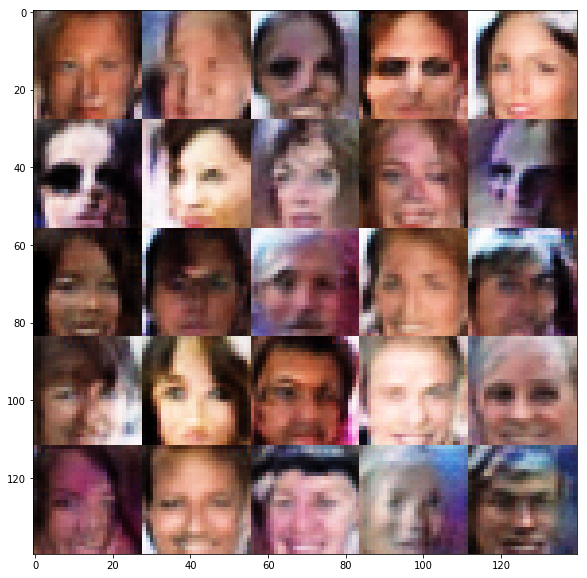

Epoch 2/3... Discriminator Loss: 1.4120... Generator Loss: 0.6485
Epoch 2/3... Discriminator Loss: 1.3806... Generator Loss: 0.6563
Epoch 2/3... Discriminator Loss: 1.3874... Generator Loss: 0.6910
Epoch 2/3... Discriminator Loss: 1.3309... Generator Loss: 0.6572
Epoch 2/3... Discriminator Loss: 1.4130... Generator Loss: 0.6241
Epoch 2/3... Discriminator Loss: 1.3922... Generator Loss: 0.8016
Epoch 2/3... Discriminator Loss: 1.3689... Generator Loss: 0.6884
Epoch 2/3... Discriminator Loss: 1.3989... Generator Loss: 0.6641
Epoch 2/3... Discriminator Loss: 1.3871... Generator Loss: 0.6728
Epoch 2/3... Discriminator Loss: 1.2830... Generator Loss: 0.6657


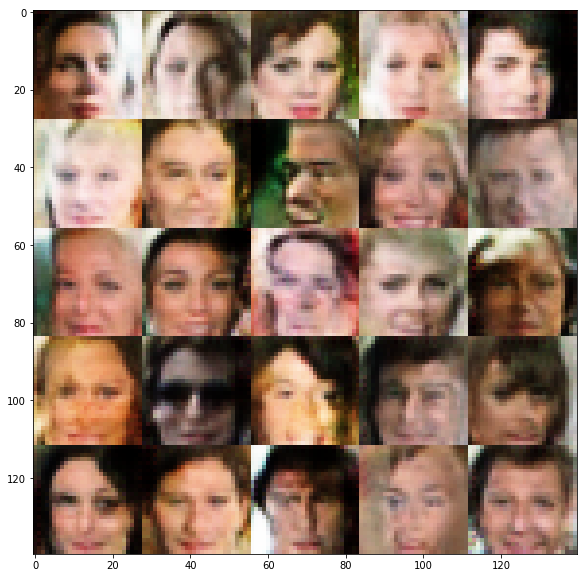

Epoch 2/3... Discriminator Loss: 1.3996... Generator Loss: 0.5326
Epoch 2/3... Discriminator Loss: 1.4271... Generator Loss: 0.5877
Epoch 2/3... Discriminator Loss: 1.3688... Generator Loss: 0.7009
Epoch 2/3... Discriminator Loss: 1.3796... Generator Loss: 0.7416
Epoch 2/3... Discriminator Loss: 1.4369... Generator Loss: 0.6096
Epoch 2/3... Discriminator Loss: 1.3963... Generator Loss: 0.7006
Epoch 2/3... Discriminator Loss: 1.3521... Generator Loss: 0.6347
Epoch 2/3... Discriminator Loss: 1.3857... Generator Loss: 0.7197
Epoch 2/3... Discriminator Loss: 1.3056... Generator Loss: 0.8682
Epoch 2/3... Discriminator Loss: 1.3753... Generator Loss: 0.7133


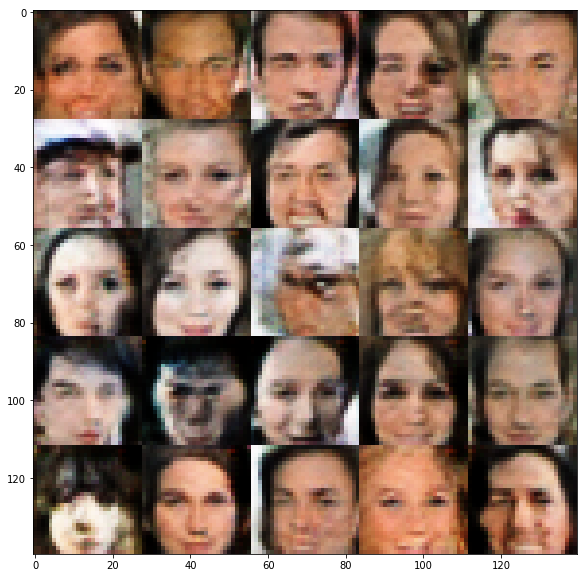

Epoch 2/3... Discriminator Loss: 1.3770... Generator Loss: 0.6605
Epoch 2/3... Discriminator Loss: 1.4347... Generator Loss: 0.6718
Epoch 2/3... Discriminator Loss: 1.4607... Generator Loss: 0.6486
Epoch 2/3... Discriminator Loss: 1.4104... Generator Loss: 0.6558
Epoch 2/3... Discriminator Loss: 1.4424... Generator Loss: 0.6018
Epoch 2/3... Discriminator Loss: 1.3311... Generator Loss: 0.6839
Epoch 2/3... Discriminator Loss: 1.4075... Generator Loss: 0.7360
Epoch 2/3... Discriminator Loss: 1.4121... Generator Loss: 0.7462
Epoch 2/3... Discriminator Loss: 1.3871... Generator Loss: 0.6643
Epoch 2/3... Discriminator Loss: 1.4100... Generator Loss: 0.6042


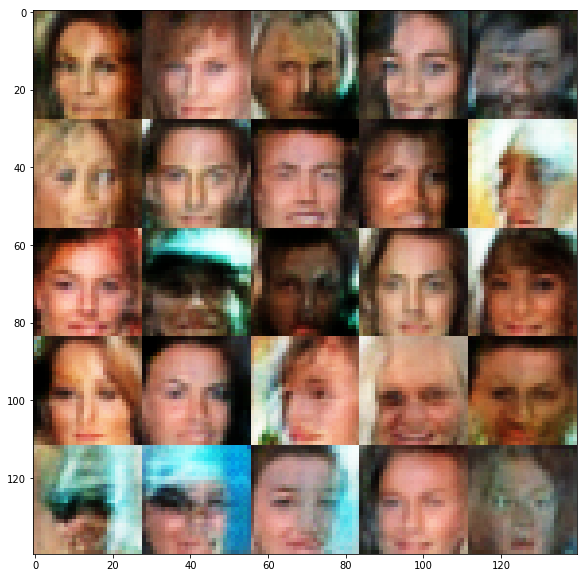

Epoch 2/3... Discriminator Loss: 1.4285... Generator Loss: 0.7106
Epoch 2/3... Discriminator Loss: 1.3706... Generator Loss: 0.6506
Epoch 2/3... Discriminator Loss: 1.4350... Generator Loss: 0.6066
Epoch 2/3... Discriminator Loss: 1.3465... Generator Loss: 0.6379
Epoch 2/3... Discriminator Loss: 1.3914... Generator Loss: 0.7173
Epoch 2/3... Discriminator Loss: 1.3411... Generator Loss: 0.7286
Epoch 3/3... Discriminator Loss: 1.4108... Generator Loss: 0.5899
Epoch 3/3... Discriminator Loss: 1.3344... Generator Loss: 0.6400
Epoch 3/3... Discriminator Loss: 1.3559... Generator Loss: 0.7939
Epoch 3/3... Discriminator Loss: 1.4351... Generator Loss: 0.7051


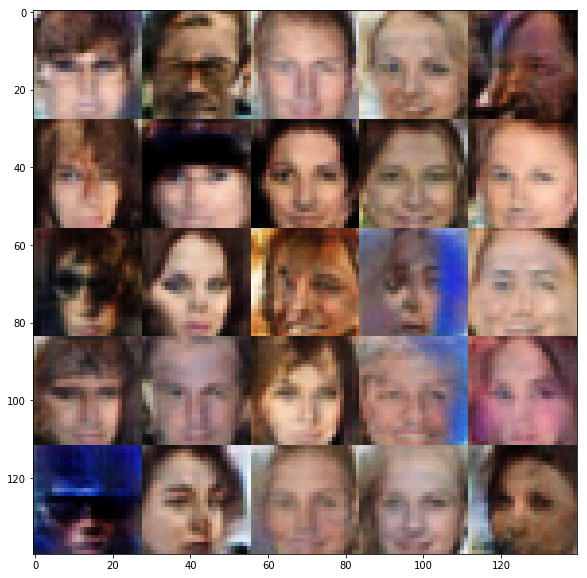

Epoch 3/3... Discriminator Loss: 1.3615... Generator Loss: 0.6614
Epoch 3/3... Discriminator Loss: 1.4998... Generator Loss: 0.6378
Epoch 3/3... Discriminator Loss: 1.3935... Generator Loss: 0.6415
Epoch 3/3... Discriminator Loss: 1.4941... Generator Loss: 0.5909
Epoch 3/3... Discriminator Loss: 1.3331... Generator Loss: 0.7011
Epoch 3/3... Discriminator Loss: 1.4311... Generator Loss: 0.6981
Epoch 3/3... Discriminator Loss: 1.4490... Generator Loss: 0.6016
Epoch 3/3... Discriminator Loss: 1.3343... Generator Loss: 0.6591
Epoch 3/3... Discriminator Loss: 1.3321... Generator Loss: 0.7122
Epoch 3/3... Discriminator Loss: 1.4100... Generator Loss: 0.6656


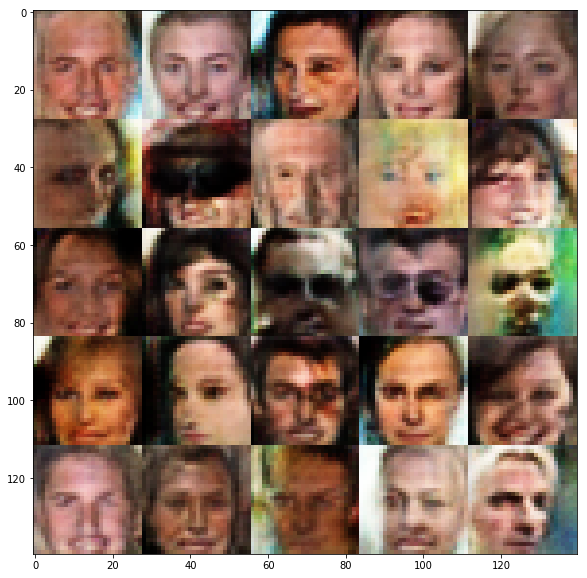

Epoch 3/3... Discriminator Loss: 1.2941... Generator Loss: 0.7535
Epoch 3/3... Discriminator Loss: 1.4192... Generator Loss: 0.6089
Epoch 3/3... Discriminator Loss: 1.4659... Generator Loss: 0.6339
Epoch 3/3... Discriminator Loss: 1.3774... Generator Loss: 0.6575
Epoch 3/3... Discriminator Loss: 1.4063... Generator Loss: 0.6717
Epoch 3/3... Discriminator Loss: 1.3893... Generator Loss: 0.6172
Epoch 3/3... Discriminator Loss: 1.3731... Generator Loss: 0.7136
Epoch 3/3... Discriminator Loss: 1.4037... Generator Loss: 0.6896
Epoch 3/3... Discriminator Loss: 1.3771... Generator Loss: 0.7072
Epoch 3/3... Discriminator Loss: 1.4297... Generator Loss: 0.6928


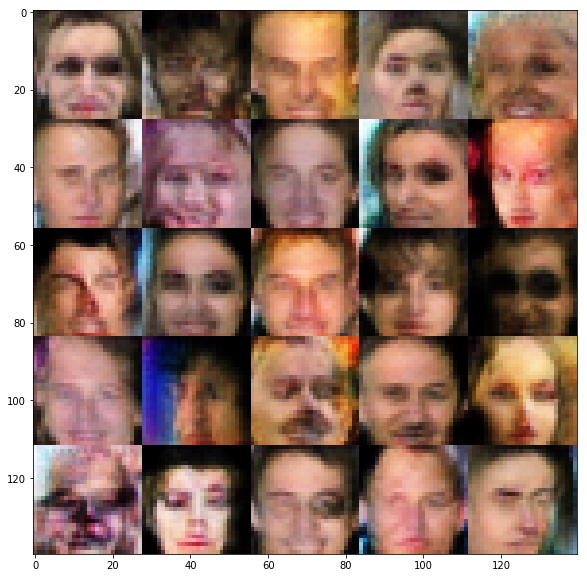

Epoch 3/3... Discriminator Loss: 1.4300... Generator Loss: 0.6383
Epoch 3/3... Discriminator Loss: 1.4098... Generator Loss: 0.7199
Epoch 3/3... Discriminator Loss: 1.3676... Generator Loss: 0.6324
Epoch 3/3... Discriminator Loss: 1.4458... Generator Loss: 0.6563
Epoch 3/3... Discriminator Loss: 1.3471... Generator Loss: 0.7144
Epoch 3/3... Discriminator Loss: 1.3899... Generator Loss: 0.6622
Epoch 3/3... Discriminator Loss: 1.3879... Generator Loss: 0.6681
Epoch 3/3... Discriminator Loss: 1.4075... Generator Loss: 0.7047
Epoch 3/3... Discriminator Loss: 1.4046... Generator Loss: 0.6994
Epoch 3/3... Discriminator Loss: 1.4088... Generator Loss: 0.6506


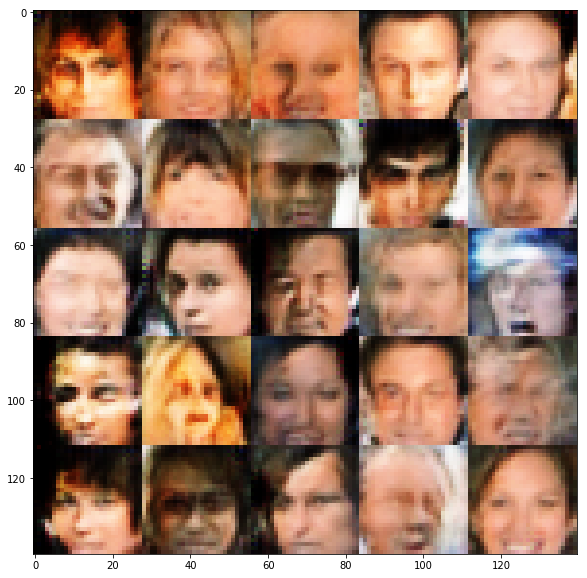

Epoch 3/3... Discriminator Loss: 1.3849... Generator Loss: 0.7722
Epoch 3/3... Discriminator Loss: 1.3661... Generator Loss: 0.8070
Epoch 3/3... Discriminator Loss: 1.3292... Generator Loss: 0.7118
Epoch 3/3... Discriminator Loss: 1.3799... Generator Loss: 0.7469
Epoch 3/3... Discriminator Loss: 1.4259... Generator Loss: 0.7014
Epoch 3/3... Discriminator Loss: 1.3804... Generator Loss: 0.6931
Epoch 3/3... Discriminator Loss: 1.4434... Generator Loss: 0.5692
Epoch 3/3... Discriminator Loss: 1.4667... Generator Loss: 0.6396
Epoch 3/3... Discriminator Loss: 1.4262... Generator Loss: 0.7382
Epoch 3/3... Discriminator Loss: 1.3221... Generator Loss: 0.7411


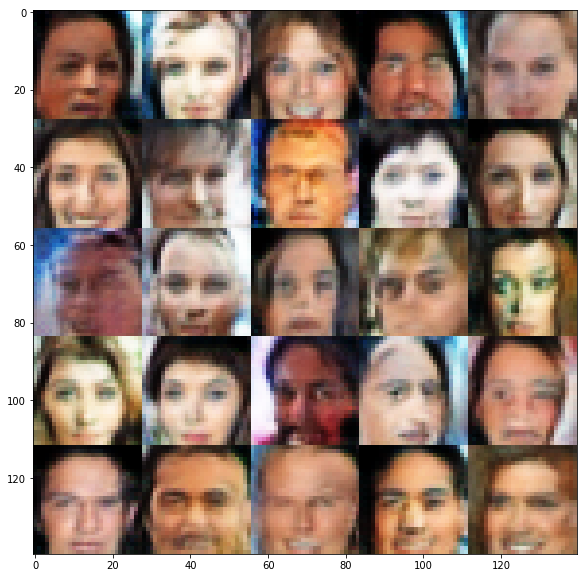

Epoch 3/3... Discriminator Loss: 1.3464... Generator Loss: 0.6725
Epoch 3/3... Discriminator Loss: 1.3743... Generator Loss: 0.6418
Epoch 3/3... Discriminator Loss: 1.3721... Generator Loss: 0.6876
Epoch 3/3... Discriminator Loss: 1.3969... Generator Loss: 0.6703
Epoch 3/3... Discriminator Loss: 1.3522... Generator Loss: 0.7043
Epoch 3/3... Discriminator Loss: 1.3878... Generator Loss: 0.6847
Epoch 3/3... Discriminator Loss: 1.3944... Generator Loss: 0.6550
Epoch 3/3... Discriminator Loss: 1.4058... Generator Loss: 0.7294
Epoch 3/3... Discriminator Loss: 1.3563... Generator Loss: 0.7059
Epoch 3/3... Discriminator Loss: 1.4240... Generator Loss: 0.6635


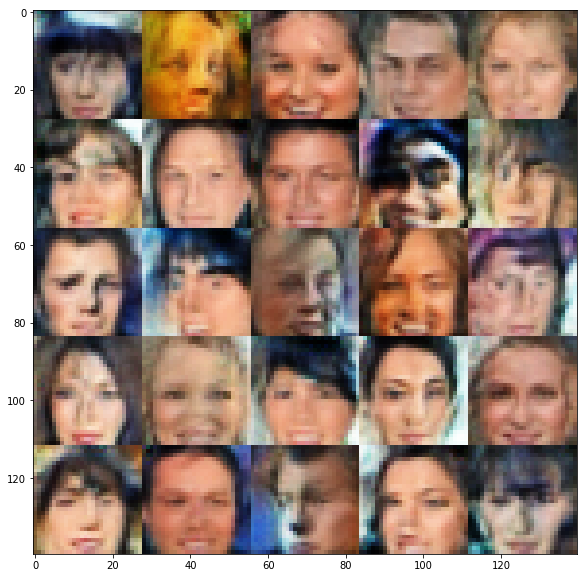

Epoch 3/3... Discriminator Loss: 1.3374... Generator Loss: 0.8204
Epoch 3/3... Discriminator Loss: 1.3545... Generator Loss: 0.7034
Epoch 3/3... Discriminator Loss: 1.1745... Generator Loss: 0.8740
Epoch 3/3... Discriminator Loss: 1.3839... Generator Loss: 0.6877
Epoch 3/3... Discriminator Loss: 1.3664... Generator Loss: 0.7079
Epoch 3/3... Discriminator Loss: 1.4247... Generator Loss: 0.5861
Epoch 3/3... Discriminator Loss: 1.3762... Generator Loss: 0.7014
Epoch 3/3... Discriminator Loss: 1.4647... Generator Loss: 0.6460
Epoch 3/3... Discriminator Loss: 1.3859... Generator Loss: 0.6657
Epoch 3/3... Discriminator Loss: 1.4204... Generator Loss: 0.6330


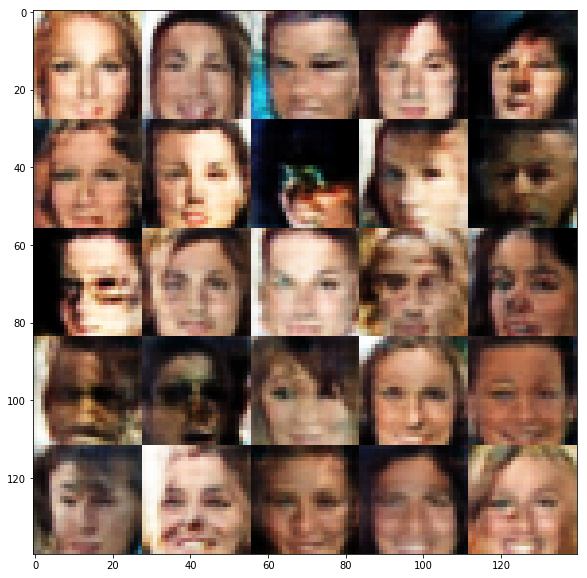

Epoch 3/3... Discriminator Loss: 1.4004... Generator Loss: 0.6771
Epoch 3/3... Discriminator Loss: 1.4425... Generator Loss: 0.6187
Epoch 3/3... Discriminator Loss: 1.4207... Generator Loss: 0.6298
Epoch 3/3... Discriminator Loss: 1.3852... Generator Loss: 0.6690
Epoch 3/3... Discriminator Loss: 1.4233... Generator Loss: 0.5844
Epoch 3/3... Discriminator Loss: 1.3774... Generator Loss: 0.6873
Epoch 3/3... Discriminator Loss: 1.3682... Generator Loss: 0.7438
Epoch 3/3... Discriminator Loss: 1.4167... Generator Loss: 0.6659
Epoch 3/3... Discriminator Loss: 1.3928... Generator Loss: 0.7728
Epoch 3/3... Discriminator Loss: 1.4117... Generator Loss: 0.6737


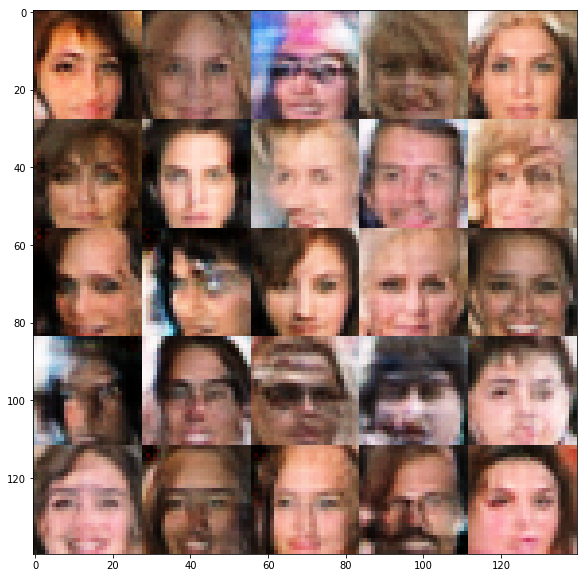

Epoch 3/3... Discriminator Loss: 1.4773... Generator Loss: 0.5242
Epoch 3/3... Discriminator Loss: 1.4900... Generator Loss: 0.6661
Epoch 3/3... Discriminator Loss: 1.4255... Generator Loss: 0.6865
Epoch 3/3... Discriminator Loss: 1.3749... Generator Loss: 0.6833
Epoch 3/3... Discriminator Loss: 1.3938... Generator Loss: 0.5510
Epoch 3/3... Discriminator Loss: 1.3213... Generator Loss: 0.6601
Epoch 3/3... Discriminator Loss: 1.3292... Generator Loss: 0.7474
Epoch 3/3... Discriminator Loss: 1.4248... Generator Loss: 0.6225
Epoch 3/3... Discriminator Loss: 1.4047... Generator Loss: 0.6374
Epoch 3/3... Discriminator Loss: 1.3623... Generator Loss: 0.6680


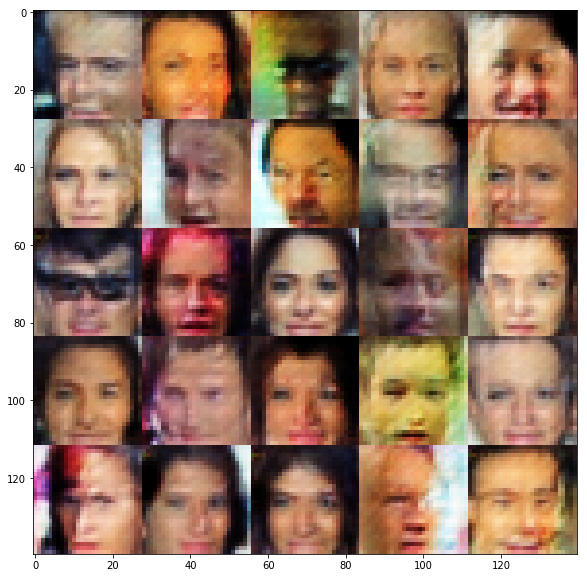

Epoch 3/3... Discriminator Loss: 1.3583... Generator Loss: 0.7475
Epoch 3/3... Discriminator Loss: 1.4083... Generator Loss: 0.6884
Epoch 3/3... Discriminator Loss: 1.4029... Generator Loss: 0.6536
Epoch 3/3... Discriminator Loss: 1.3941... Generator Loss: 0.7408
Epoch 3/3... Discriminator Loss: 1.4526... Generator Loss: 0.6747
Epoch 3/3... Discriminator Loss: 1.3841... Generator Loss: 0.7437
Epoch 3/3... Discriminator Loss: 1.4097... Generator Loss: 0.6489
Epoch 3/3... Discriminator Loss: 1.3713... Generator Loss: 0.6756
Epoch 3/3... Discriminator Loss: 1.4476... Generator Loss: 0.7079
Epoch 3/3... Discriminator Loss: 1.4164... Generator Loss: 0.6715


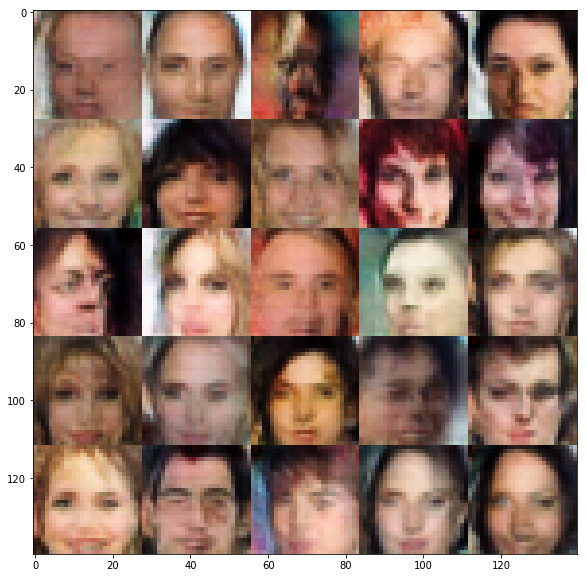

Epoch 3/3... Discriminator Loss: 1.4355... Generator Loss: 0.6953
Epoch 3/3... Discriminator Loss: 1.3689... Generator Loss: 0.6446
Epoch 3/3... Discriminator Loss: 1.3010... Generator Loss: 0.6801
Epoch 3/3... Discriminator Loss: 1.4614... Generator Loss: 0.6055
Epoch 3/3... Discriminator Loss: 1.3796... Generator Loss: 0.6848
Epoch 3/3... Discriminator Loss: 1.4185... Generator Loss: 0.6573
Epoch 3/3... Discriminator Loss: 1.4696... Generator Loss: 0.6236
Epoch 3/3... Discriminator Loss: 1.3871... Generator Loss: 0.6498
Epoch 3/3... Discriminator Loss: 1.4263... Generator Loss: 0.6315
Epoch 3/3... Discriminator Loss: 1.4559... Generator Loss: 0.7022


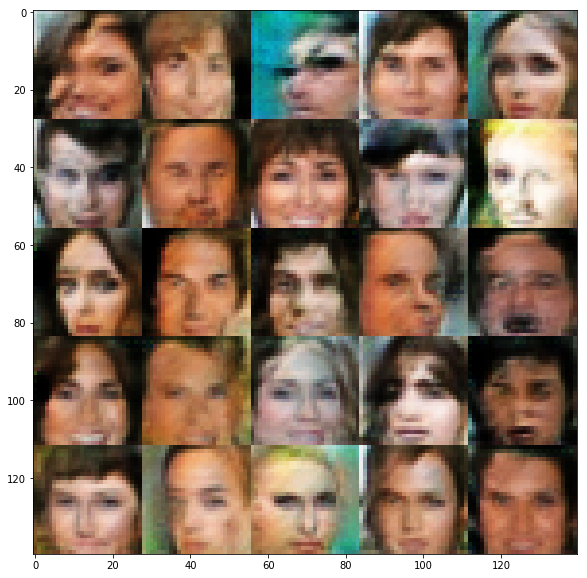

Epoch 3/3... Discriminator Loss: 1.3791... Generator Loss: 0.6890
Epoch 3/3... Discriminator Loss: 1.3768... Generator Loss: 0.5959
Epoch 3/3... Discriminator Loss: 1.4288... Generator Loss: 0.6814
Epoch 3/3... Discriminator Loss: 1.4327... Generator Loss: 0.6520
Epoch 3/3... Discriminator Loss: 1.4431... Generator Loss: 0.7332
Epoch 3/3... Discriminator Loss: 1.3672... Generator Loss: 0.6806
Epoch 3/3... Discriminator Loss: 1.4124... Generator Loss: 0.6506
Epoch 3/3... Discriminator Loss: 1.3921... Generator Loss: 0.6482
Epoch 3/3... Discriminator Loss: 1.4473... Generator Loss: 0.5966
Epoch 3/3... Discriminator Loss: 1.4156... Generator Loss: 0.6978


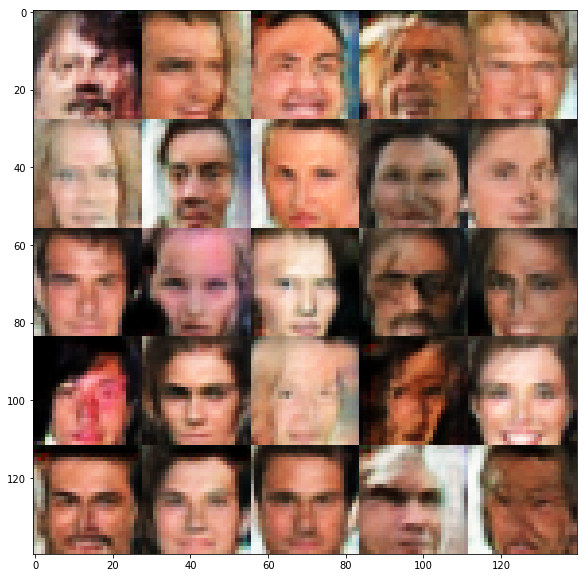

Epoch 3/3... Discriminator Loss: 1.3804... Generator Loss: 0.6729
Epoch 3/3... Discriminator Loss: 1.4180... Generator Loss: 0.6903
Epoch 3/3... Discriminator Loss: 1.3510... Generator Loss: 0.6979
Epoch 3/3... Discriminator Loss: 1.4455... Generator Loss: 0.7470
Epoch 3/3... Discriminator Loss: 1.4093... Generator Loss: 0.6119
Epoch 3/3... Discriminator Loss: 1.4843... Generator Loss: 0.6051
Epoch 3/3... Discriminator Loss: 1.4201... Generator Loss: 0.6668
Epoch 3/3... Discriminator Loss: 1.3879... Generator Loss: 0.7222
Epoch 3/3... Discriminator Loss: 1.3788... Generator Loss: 0.6516
Epoch 3/3... Discriminator Loss: 1.4498... Generator Loss: 0.5710


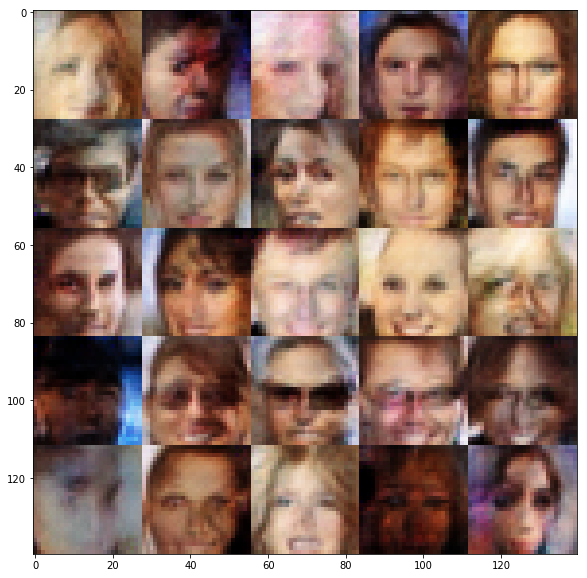

Epoch 3/3... Discriminator Loss: 1.3885... Generator Loss: 0.6425
Epoch 3/3... Discriminator Loss: 1.3779... Generator Loss: 0.6780
Epoch 3/3... Discriminator Loss: 1.3912... Generator Loss: 0.7352
Epoch 3/3... Discriminator Loss: 1.3707... Generator Loss: 0.7065
Epoch 3/3... Discriminator Loss: 1.3685... Generator Loss: 0.6791
Epoch 3/3... Discriminator Loss: 1.4329... Generator Loss: 0.6200
Epoch 3/3... Discriminator Loss: 1.3897... Generator Loss: 0.7312
Epoch 3/3... Discriminator Loss: 1.4356... Generator Loss: 0.6496
Epoch 3/3... Discriminator Loss: 1.3892... Generator Loss: 0.6528
Epoch 3/3... Discriminator Loss: 1.4322... Generator Loss: 0.7286


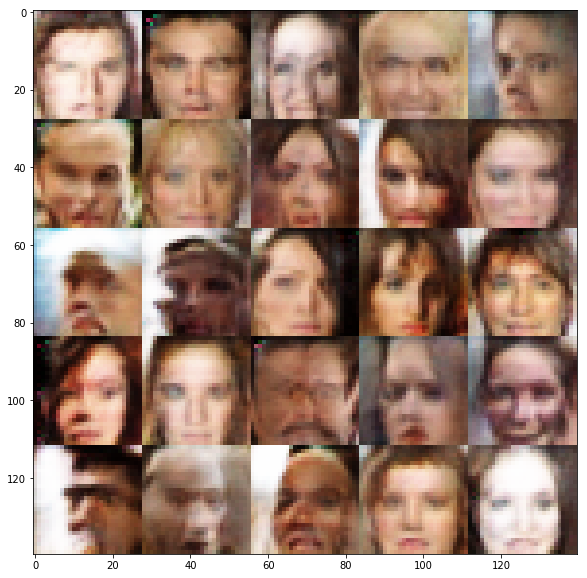

Epoch 3/3... Discriminator Loss: 1.4208... Generator Loss: 0.6719
Epoch 3/3... Discriminator Loss: 1.3773... Generator Loss: 0.7287
Epoch 3/3... Discriminator Loss: 1.4596... Generator Loss: 0.6707
Epoch 3/3... Discriminator Loss: 1.3951... Generator Loss: 0.6687
Epoch 3/3... Discriminator Loss: 1.4059... Generator Loss: 0.6916
Epoch 3/3... Discriminator Loss: 1.4375... Generator Loss: 0.6033
Epoch 3/3... Discriminator Loss: 1.4597... Generator Loss: 0.6200
Epoch 3/3... Discriminator Loss: 1.3898... Generator Loss: 0.6797
Epoch 3/3... Discriminator Loss: 1.3600... Generator Loss: 0.6545
Epoch 3/3... Discriminator Loss: 1.3762... Generator Loss: 0.7023


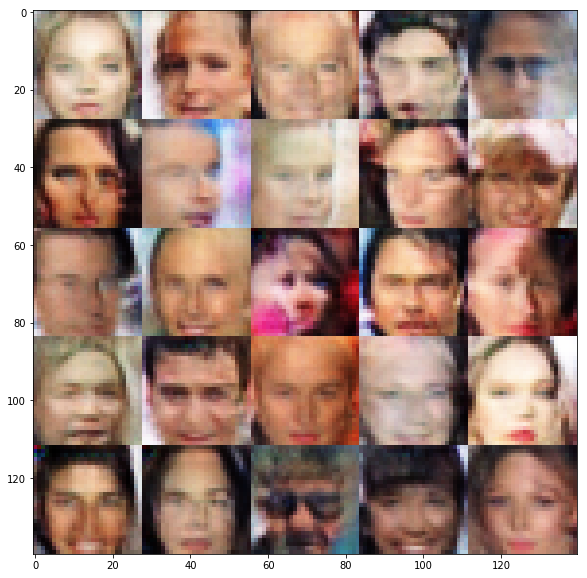

Epoch 3/3... Discriminator Loss: 1.3729... Generator Loss: 0.6603
Epoch 3/3... Discriminator Loss: 1.3825... Generator Loss: 0.7207
Epoch 3/3... Discriminator Loss: 1.3663... Generator Loss: 0.6927
Epoch 3/3... Discriminator Loss: 1.4795... Generator Loss: 0.6753
Epoch 3/3... Discriminator Loss: 1.4024... Generator Loss: 0.6513
Epoch 3/3... Discriminator Loss: 1.3882... Generator Loss: 0.6435
Epoch 3/3... Discriminator Loss: 1.3779... Generator Loss: 0.6556
Epoch 3/3... Discriminator Loss: 1.3945... Generator Loss: 0.6641
Epoch 3/3... Discriminator Loss: 1.3852... Generator Loss: 0.6718
Epoch 3/3... Discriminator Loss: 1.4053... Generator Loss: 0.6788


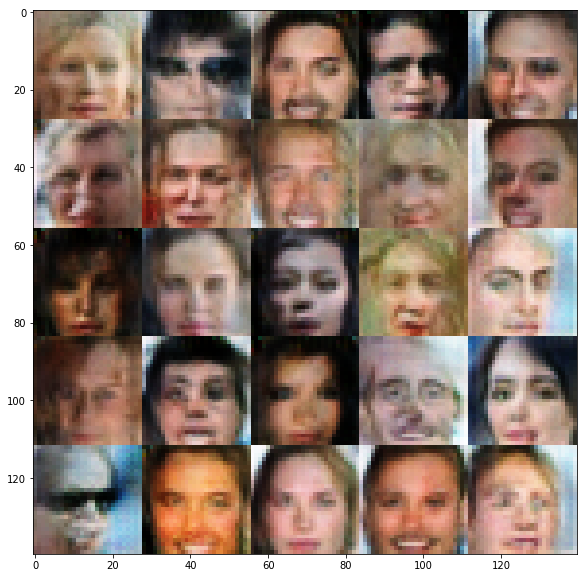

Epoch 3/3... Discriminator Loss: 1.3588... Generator Loss: 0.6835
Epoch 3/3... Discriminator Loss: 1.3684... Generator Loss: 0.7181
Epoch 3/3... Discriminator Loss: 1.2464... Generator Loss: 0.6815
Epoch 3/3... Discriminator Loss: 1.3372... Generator Loss: 0.7399


In [17]:
batch_size = 64
z_dim = 150
learning_rate = 0.0003
beta1 = 0.45


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 3

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.